#Global Clustering of Forwards: Serie A, Ligue 1 & La Liga (2023–24)

In this notebook, I’m combining forward data from Serie A, Ligue 1, and La Liga to build a global clustering model. The goal is to identify common role types among forwards across leagues based on their actual contribution on the pitch.

Before this step, I prepared each league individually:

-Cleaned raw data

-Filtered players with ≥540 minutes played to ensure meaningful sample sizes

-Selected key per 90 metrics related to attacking output, creativity, ball progression, and duels

These include:

-Goals (goals_p90)

-Shot volume (shots_total_p90)

-Dribbling activity (dribbles_attempts_p90, dribbles_success_p90, dribbles_success_perc)

-Playmaking (assists_p90, passes_key_p90, passes_total_p90, passes_accuracy_perc)

-Physical contests (duels_total_p90, duels_won_p90)

And one-hot encoded team affiliation, to retain tactical system context

I also kept each player’s team, league, and name to make the final clustering traceable and interpretable.

In this notebook, I’ll:

-Merge the forward datasets from the three leagues

-Scale the features across the combined pool

-Apply Principal Component Analysis (PCA) to reduce feature space

-Run K-Means clustering to find tactical role groups

-Interpret the clusters and visualize them with centroids and radar plots

This will help me explore which types of forwards exist across leagues and how they compare tactically, beyond club or competition labels.

#Adding 'league' Column to Each Dataset

To ensure traceability in the final global clustering, I’m assigning a league label to each of the preprocessed encoded forward datasets. This allows me to track player origins across Serie A, Ligue 1, and La Liga once all datasets are merged into a single pool.

In [ ]:
import pandas as pd
# --- Serie A ---
df_seriea = pd.read_csv("seriea_forwards_2023_24_preprocessed_encoded_team.csv")
df_seriea["league"] = "Serie A"
df_seriea.to_csv("seriea_forwards_2023_24_encoded_with_league.csv", index=False)

# --- Ligue 1 ---
df_ligue1 = pd.read_csv("ligue1_forwards_2023_24_preprocessed_encoded_team.csv")
df_ligue1["league"] = "Ligue 1"
df_ligue1.to_csv("ligue1_forwards_2023_24_encoded_with_league.csv", index=False)

# --- La Liga ---
df_laliga = pd.read_csv("laliga_forwards_2023_24_preprocessed_encoded_team.csv")
df_laliga["league"] = "La Liga"
df_laliga.to_csv("laliga_forwards_2023_24_encoded_with_league.csv", index=False)

Ensuring that all columns are the same for each league's dataset.

In [ ]:
import pandas as pd

# --- Load and tag Serie A encoded forward dataset ---
df_seriea = pd.read_csv("seriea_forwards_2023_24_preprocessed_encoded_team.csv")
df_seriea["league"] = "Serie A"

# --- Load and tag Ligue 1 encoded forward dataset ---
df_ligue1 = pd.read_csv("ligue1_forwards_2023_24_preprocessed_encoded_team.csv")
df_ligue1["league"] = "Ligue 1"

# --- Load and tag La Liga encoded forward dataset ---
df_laliga = pd.read_csv("laliga_forwards_2023_24_preprocessed_encoded_team.csv")
df_laliga["league"] = "La Liga"

# --- Print column names ---
print("\n📁 Serie A columns:")
print(df_seriea.columns.to_list())

print("\n📁 Ligue 1 columns:")
print(df_ligue1.columns.to_list())

print("\n📁 La Liga columns:")
print(df_laliga.columns.to_list())

# --- Preview sample rows from each dataset (including league column) ---
print("\n🔍 Serie A sample:")
print(df_seriea[["name", "team_clean", "league", "goals_p90", "assists_p90"]].head(2).to_string())

print("\n🔍 Ligue 1 sample:")
print(df_ligue1[["name", "team_clean", "league", "goals_p90", "assists_p90"]].head(2).to_string())

print("\n🔍 La Liga sample:")
print(df_laliga[["name", "team_clean", "league", "goals_p90", "assists_p90"]].head(2).to_string())



📁 Serie A columns:
['name', 'position', 'minutes', 'duels_total_api', 'duels_won_api', 'goals_total_api', 'shots_total_api', 'shots_on_target_api', 'assists_total_api', 'dribbles_attempts_api', 'dribbles_success_api', 'touches_total_api', 'passes_key_api', 'passes_total_api', 'passes_accuracy_perc', 'shots_on_target_perc', 'dribbles_success_perc', 'name_clean', 'team_clean', 'Rk_fbref_att', 'duels_total_p90', 'duels_won_p90', 'goals_p90', 'shots_total_p90', 'shots_on_target_p90', 'assists_p90', 'dribbles_attempts_p90', 'dribbles_success_p90', 'touches_total_p90', 'passes_key_p90', 'passes_total_p90', 'team_AS Roma', 'team_Atalanta', 'team_Bologna', 'team_Cagliari', 'team_Empoli', 'team_Fiorentina', 'team_Genoa', 'team_Inter', 'team_Juventus', 'team_Lazio', 'team_Lecce', 'team_Monza', 'team_Napoli', 'team_Salernitana', 'team_Sassuolo', 'team_Torino', 'team_Udinese', 'team_Verona', 'league']

📁 Ligue 1 columns:
['name', 'position', 'minutes', 'duels_total_api', 'duels_won_api', 'goals_t

To ensure column consistency across datasets, I’m removing Rk_fbref_att from Serie A and Ligue 1. This column was a leftover ranking index from FBref and isn’t relevant for clustering or analysis.

In [ ]:
import pandas as pd

# --- Load updated Serie A forward dataset ---
df_seriea = pd.read_csv("seriea_forwards_2023_24_encoded_with_league.csv")
df_seriea.drop(columns="Rk_fbref_att", inplace=True)

# --- Load updated Ligue 1 forward dataset ---
df_ligue1 = pd.read_csv("ligue1_forwards_2023_24_encoded_with_league.csv")
df_ligue1.drop(columns="Rk_fbref_att", inplace=True)

# --- Load updated La Liga forward dataset (Rk_fbref_att not present) ---
df_laliga = pd.read_csv("laliga_forwards_2023_24_encoded_with_league.csv")

# --- Confirm cleanup worked and preview column counts ---
print("✅ Cleaned datasets loaded.")
print(f"Serie A columns: {len(df_seriea.columns)}")
print(f"Ligue 1 columns: {len(df_ligue1.columns)}")
print(f"La Liga columns: {len(df_laliga.columns)}")


✅ Cleaned datasets loaded.
Serie A columns: 49
Ligue 1 columns: 48
La Liga columns: 47


Before merging or scaling the forward datasets, I’m checking each one for missing values. This helps identify any columns that need to be dropped, imputed, or handled carefully to avoid errors in clustering or PCA.

In [ ]:
# --- Missing value count per column (Serie A) ---
print("\n🔎 Missing values in Serie A:")
print(df_seriea.isnull().sum().sort_values(ascending=False))

# --- Missing value count per column (Ligue 1) ---
print("\n🔎 Missing values in Ligue 1:")
print(df_ligue1.isnull().sum().sort_values(ascending=False))

# --- Missing value count per column (La Liga) ---
print("\n🔎 Missing values in La Liga:")
print(df_laliga.isnull().sum().sort_values(ascending=False))



🔎 Missing values in Serie A:
name                     0
position                 0
minutes                  0
duels_total_api          0
duels_won_api            0
goals_total_api          0
shots_total_api          0
shots_on_target_api      0
assists_total_api        0
dribbles_attempts_api    0
dribbles_success_api     0
touches_total_api        0
passes_key_api           0
passes_total_api         0
passes_accuracy_perc     0
shots_on_target_perc     0
dribbles_success_perc    0
name_clean               0
team_clean               0
duels_total_p90          0
duels_won_p90            0
goals_p90                0
shots_total_p90          0
shots_on_target_p90      0
assists_p90              0
dribbles_attempts_p90    0
dribbles_success_p90     0
touches_total_p90        0
passes_key_p90           0
passes_total_p90         0
team_AS Roma             0
team_Atalanta            0
team_Bologna             0
team_Cagliari            0
team_Empoli              0
team_Fiorentina          

No missing values.

#1. Merging the 3 datasets

With all three league datasets cleaned and consistently labeled, I’m now merging them into one global DataFrame. This combined pool includes all preprocessed metrics, one-hot encoded team flags, and identifiers like name, team_clean, and league. It’s the foundation for global feature scaling and clustering.

In [ ]:
import pandas as pd

# --- Load cleaned forward datasets (with league column and no Rk_fbref_att) ---
df_seriea = pd.read_csv("seriea_forwards_2023_24_encoded_with_league.csv")
df_ligue1 = pd.read_csv("ligue1_forwards_2023_24_encoded_with_league.csv")
df_laliga = pd.read_csv("laliga_forwards_2023_24_encoded_with_league.csv")

# --- Drop Rk_fbref_att if still present (just in case)
df_seriea = df_seriea.drop(columns="Rk_fbref_att", errors="ignore")
df_ligue1 = df_ligue1.drop(columns="Rk_fbref_att", errors="ignore")

# --- Merge the datasets
df_global_forwards_raw = pd.concat([df_seriea, df_ligue1, df_laliga], ignore_index=True)

# --- Save to CSV
df_global_forwards_raw.to_csv("global_forwards_2023_24_encoded.csv", index=False)

# --- Preview
print(f"✅ Global forward dataset saved — shape: {df_global_forwards_raw.shape}")
print(df_global_forwards_raw[["name", "team_clean", "league", "goals_p90", "assists_p90"]].head())


✅ Global forward dataset saved — shape: (130, 82)
         name team_clean   league  goals_p90  assists_p90
0   F. Caputo     empoli  Serie A   0.211931     0.000000
1  I. Success    udinese  Serie A   0.103448     0.103448
2   S. Azmoun       roma  Serie A   0.475352     0.000000
3   Dany Mota      monza  Serie A   0.175012     0.131259
4  A. Petagna   cagliari  Serie A   0.090090     0.090090


#2. EDA (EXPLORATORY DATA ANALYSIS)

Before initiating PCA and clustering, this section provides a tactical overview of the global forward dataset for the 2023–24 season. It summarizes key performance metrics—normalized per 90 minutes or expressed as percentages—and inspects missing values, average contributions, and metric classifications. By reviewing variables like goals, shot volume, passing, dribbling, and duels across leagues, we establish a contextual foundation to interpret cluster results and ensure modeling transparency.

In [ ]:
import pandas as pd

# --- Load the encoded global forward dataset ---
try:
    df_global_encoded = pd.read_csv("global_forwards_2023_24_encoded.csv")
    print("✅ Global forward dataset loaded successfully for EDA overview.")
except FileNotFoundError:
    print("❌ Error: 'global_forwards_2023_24_encoded.csv' not found.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error during file loading: {e}")
    exit()

# --- Section Intro ---
print("\n# 2. EDA (Exploratory Data Analysis)")
print("## 2.1 Tactical Overview of Global Forward Pool")
print("This section previews identifiers and contribution metrics used for clustering, checking structure, completeness, and average values across the dataset.")

# --- Identifier Columns ---
identifier_columns = [
    "name", "name_clean", "team", "team_clean", "league", "minutes", "position"
]

print("\n### Identifier Variables:")
existing_ids = [col for col in identifier_columns if col in df_global_encoded.columns]
for col in existing_ids:
    print(f"    * {col}")

# --- Clustering Metrics ---
clustering_metrics = [
    "goals_p90", "shots_total_p90", "shots_on_target_p90", "shots_on_target_perc",
    "assists_p90", "passes_key_p90", "passes_total_p90", "passes_accuracy_perc",
    "dribbles_attempts_p90", "dribbles_success_p90", "dribbles_success_perc",
    "touches_total_p90", "duels_total_p90", "duels_won_p90"
]

print("\n### Performance Metrics Used for Clustering:")
existing_metrics = [col for col in clustering_metrics if col in df_global_encoded.columns]
for metric in existing_metrics:
    print(f"    * {metric}")

# --- Dataset Dimensions ---
print(f"\n### Dataset Overview:")
print(f"    * Total Players: {df_global_encoded.shape[0]}")
print(f"    * Total Columns: {df_global_encoded.shape[1]}")

# --- Missing Values Check (Safeguarded) ---
missing_check_cols = existing_ids + existing_metrics
missing_values = df_global_encoded[missing_check_cols].isnull().sum()
missing_summary = missing_values[missing_values > 0]

if missing_summary.empty:
    print("    ✅ No missing values detected in key columns.")
else:
    print("    ⚠️ Missing values found:")
    print(missing_summary.to_string())

# --- Mean Values of Clustering Metrics ---
print("\n### Mean Contribution Metrics Across Global Pool:")
for metric in existing_metrics:
    avg = df_global_encoded[metric].mean()
    unit = "%" if "perc" in metric else ""
    print(f"    * {metric}: {avg:.2f}{unit}")


✅ Global forward dataset loaded successfully for EDA overview.

# 2. EDA (Exploratory Data Analysis)
## 2.1 Tactical Overview of Global Forward Pool
This section previews identifiers and contribution metrics used for clustering, checking structure, completeness, and average values across the dataset.

### Identifier Variables:
    * name
    * name_clean
    * team_clean
    * league
    * minutes
    * position

### Performance Metrics Used for Clustering:
    * goals_p90
    * shots_total_p90
    * shots_on_target_p90
    * shots_on_target_perc
    * assists_p90
    * passes_key_p90
    * passes_total_p90
    * passes_accuracy_perc
    * dribbles_attempts_p90
    * dribbles_success_p90
    * dribbles_success_perc
    * touches_total_p90
    * duels_total_p90
    * duels_won_p90

### Dataset Overview:
    * Total Players: 130
    * Total Columns: 82
    ✅ No missing values detected in key columns.

### Mean Contribution Metrics Across Global Pool:
    * goals_p90: 0.32
    * shots_tot

## 2.1 EDA – GLOBAL FORWARDS
## Variable Type Classification & Overview – FORWARDS
As I move into the Exploratory Data Analysis (EDA) phase for Ligue 1 forwards, it's essential to clearly classify the types of variables in my cleaned dataset. This helps me understand which features are suitable for clustering and how to interpret them.

### Variable Type Classification
* Identifier Variables:
These variables are crucial for identifying and labeling individual players or teams. While I won't use them directly in the clustering algorithms, they are invaluable for interpreting the clusters and displaying results later.

name (Original player name from API)

team (Original team name from API)

name_clean (Cleaned player name for merging)

team_clean (Cleaned team name for merging)

* Categorical Variables:
These variables represent distinct categories. Currently, I'm not using them for direct clustering, but they can be very useful for filtering, grouping, or segmenting the data if needed for deeper analysis.

position (Player's primary position)

* Numerical Variables:
These are the continuous features that provide quantitative insights into player performance. They are the primary inputs for my clustering analysis. All relevant metrics have been normalized to a "per 90 minutes" basis or are already percentages, ensuring fair comparison regardless of playing time.

### Feature Groups
* Match Involvement:
minutes (Total minutes played — useful for context, but not a direct clustering feature)

* Goal Scoring & Shot Creation (Per 90 Minutes & Percentages):
goals_p90

shots_total_p90

shots_on_target_p90

shots_on_target_perc (Percentage)

⚠️ Note: GCA90 and SCA90 were not available in the final Ligue 1 dataset due to missing FBref attacking data for some players.

* Dribbling & Ball Progression (Per 90 Minutes & Percentages):
dribbles_attempts_p90

dribbles_success_p90

dribbles_success_perc (Percentage)

touches_total_p90

* Playmaking & Link-up Play (Per 90 Minutes & Percentages):
assists_p90

passes_key_p90

passes_total_p90

passes_accuracy_perc (Percentage)

* Offensive Engagement (Per 90 Minutes):
duels_total_p90

duels_won_p90

### Dataset Overview:
    * Total Players: 130
    * Total Columns: 82
    ✅ No missing values detected in key columns.

### Mean Contribution Metrics Across Global Pool:
    * goals_p90: 0.32
    * shots_total_p90: 1.83
    * shots_on_target_p90: 0.00
    * shots_on_target_perc: 0.00%
    * assists_p90: 0.14
    * passes_key_p90: 1.30
    * passes_total_p90: 24.72
    * passes_accuracy_perc: 72.05%
    * dribbles_attempts_p90: 2.65
    * dribbles_success_p90: 1.23
    * dribbles_success_perc: 46.15%
    * touches_total_p90: 0.00
    * duels_total_p90: 11.78
    * duels_won_p90: 5.11

    Even though there no missing values, shots_on_target_p90, shots_on_target_perc and touches_total_p90 are 0 , so I will have to exclude them later.

Following I am plotting distributions of key metrics for forwards to understand typical player behavior and detect skewness. These visualizations help us grasp how common or rare certain statistical outputs are for forwards.

✅ Encoded global forward dataset loaded for metric distribution plots.


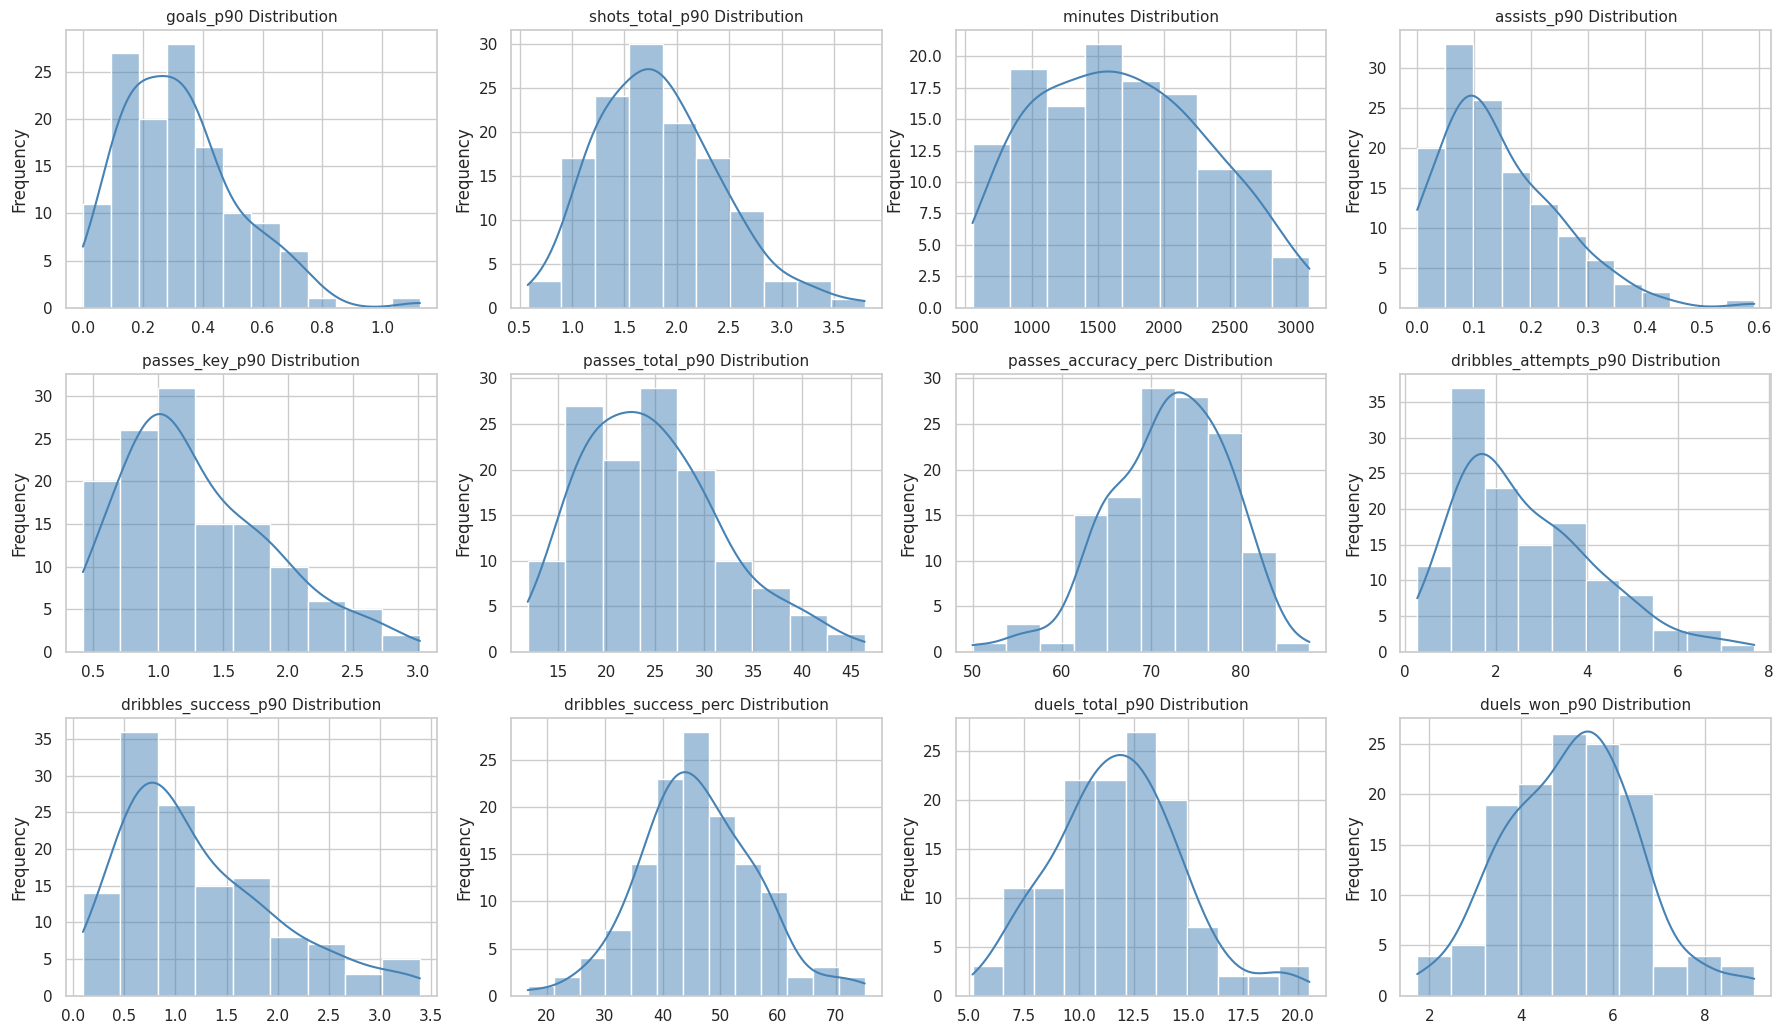

✅ Distribution plots for global forward metrics generated successfully.


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Set Seaborn visual style ---
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (18, 14)

# --- Load the encoded global forward dataset ---
try:
    df_global_encoded = pd.read_csv("global_forwards_2023_24_encoded.csv")
    print("✅ Encoded global forward dataset loaded for metric distribution plots.")
except FileNotFoundError:
    print("❌ Error: 'global_forwards_2023_24_encoded.csv' not found.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error loading file: {e}")
    exit()

# --- Define performance metrics used in clustering ---
key_metrics = [
    "goals_p90", "shots_total_p90", "minutes",
    "assists_p90", "passes_key_p90", "passes_total_p90", "passes_accuracy_perc",
    "dribbles_attempts_p90", "dribbles_success_p90", "dribbles_success_perc",
     "duels_total_p90", "duels_won_p90"
]

# --- Create subplot grid ---
num_metrics = len(key_metrics)
ncols = 4
nrows = (num_metrics + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4.5, nrows * 3.5))
axes = axes.flatten()

# --- Plot each feature with KDE overlay ---
for i, metric in enumerate(key_metrics):
    if metric in df_global_encoded.columns:
        sns.histplot(data=df_global_encoded, x=metric, kde=True, ax=axes[i], color='steelblue')
        axes[i].set_title(f"{metric} Distribution", fontsize=11)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("Frequency")
    else:
        print(f"⚠️ '{metric}' not found in dataset. Skipping.")
        fig.delaxes(axes[i])

# --- Remove empty axes if any ---
for j in range(num_metrics, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

print("✅ Distribution plots for global forward metrics generated successfully.")


# Interpretation of the Distribution Plots – Global Forwards

These visualizations provide insights into the spread and typical values for key performance metrics among global forwards (Serie A, Ligue 1, and La Liga) with at least 540 minutes played in the 2023/24 season.

**Match Involvement**

*   **minutes**: The distribution shows a wide range of minutes played, reflecting the filtering criteria (≥540 minutes) but also the varying levels of player involvement across the season. There's a concentration of players around the average minutes played, with tails extending to players who played significantly more or less time.

**Goal Scoring & Shot Creation**

*   **goals_p90**: The distribution shows that most global forwards in this sample score under 0.4 goals per 90 minutes. There's a clear right skew, indicating a few players are significantly more prolific scorers.
*   **shots_total_p90**: Most forwards take between 1 to 2.5 shots per 90 minutes. Similar to goals, a smaller group of players have a much higher volume of shots, pushing the distribution to the right.
*   **assists_p90**: The majority of forwards have relatively low assists per 90, mostly under 0.2. The distribution is heavily skewed towards zero, indicating that high assist numbers per 90 are less common for the typical forward in this sample.
*   **passes_key_p90**: Key passes per 90 show a distribution with a peak around 0.5 to 1.5, but with a tail extending to players who create significantly more chances.
*   **passes_total_p90**: The total number of passes per 90 varies, with a concentration between 15 and 30 passes per 90, but also players with much higher passing volumes, suggesting different levels of involvement in build-up play.
*   **passes_accuracy_perc**: The percentage of accurate passes shows a broad spread, with a significant number of players having percentages between 60% and 80%, indicating variability in passing efficiency.

**Dribbling & Ball Progression**

*   **dribbles_attempts_p90**: Forwards vary considerably in how often they attempt dribbles, with a concentration between 1 and 3 attempts per 90, but also players attempting significantly more, showing a range from less frequent dribblers to consistent ball carriers.
*   **dribbles_success_p90**: Successful dribbles per 90 are generally lower than attempts, mostly concentrated below 1.5 per 90, indicating that while attempts are frequent for some, successful outcomes are less so across the board.
*   **dribbles_success_perc**: The percentage of successful dribbles shows a broad distribution, with peaks around 40-60%, indicating variability in dribbling effectiveness.

**Offensive Engagement**

*   **duels_total_p90**: Total duels per 90 show a wide range, with a concentration between 8 and 15, reflecting varying levels of physical engagement.
*   **duels_won_p90**: Duels won per 90 are generally lower than total duels, mostly concentrated between 3 and 7, indicating that winning duels consistently at a high rate is less common for the typical forward in this sample.

I am creating a heatmap to visualize correlations between tactical features

-This helps identify which stats tend to move together and which ones are independent

-Useful to understand potential clusters and avoid feature redundancy

✅ Encoded global forward dataset loaded successfully for correlation analysis.


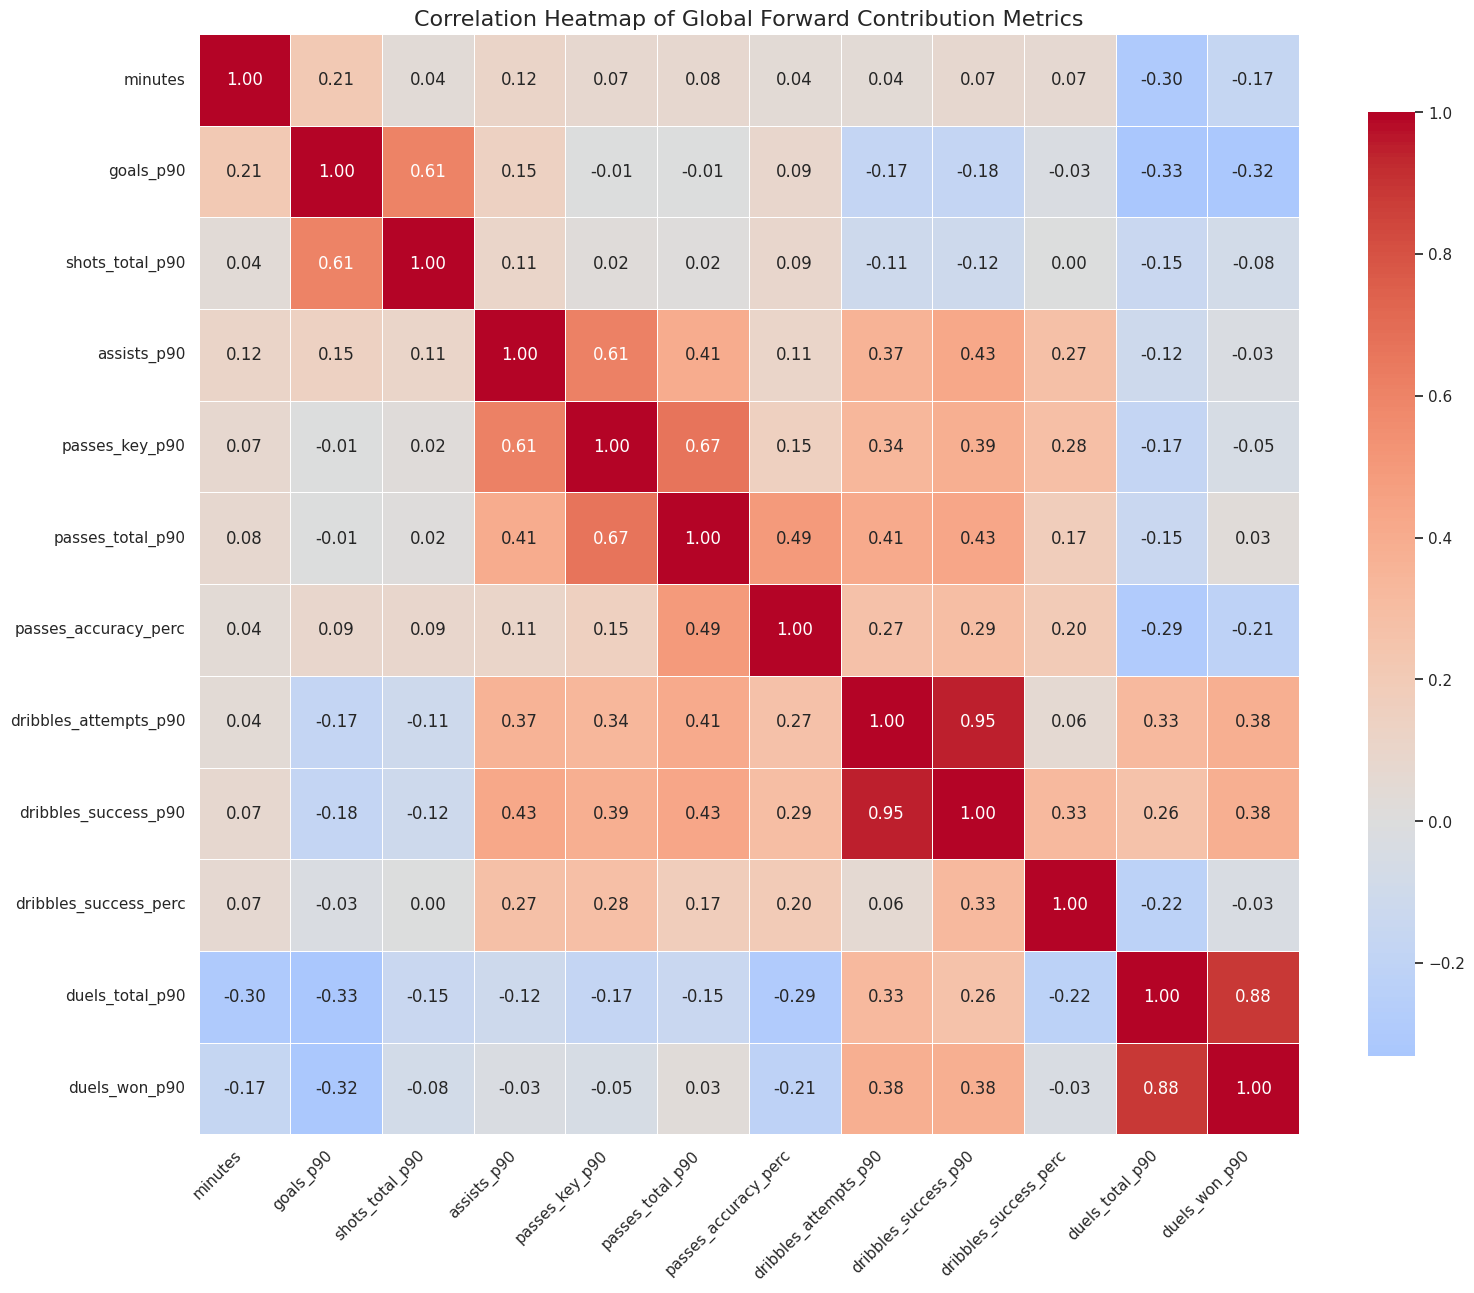

✅ Correlation heatmap generated successfully.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Set Seaborn style ---
sns.set(style="whitegrid")

# --- Load encoded global forward dataset ---
try:
    df_global_encoded = pd.read_csv("global_forwards_2023_24_encoded.csv")
    print("✅ Encoded global forward dataset loaded successfully for correlation analysis.")
except FileNotFoundError:
    print("❌ Error: 'global_forwards_2023_24_encoded.csv' not found.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error during file loading: {e}")
    exit()

# --- Define relevant metrics for clustering (excluding 0-value fields) ---
corr_metrics = [
    "minutes", "goals_p90", "shots_total_p90",
    "assists_p90", "passes_key_p90", "passes_total_p90", "passes_accuracy_perc",
    "dribbles_attempts_p90", "dribbles_success_p90", "dribbles_success_perc",
    "duels_total_p90", "duels_won_p90"
]

# --- Safeguard: Keep only existing columns ---
valid_corr_metrics = [m for m in corr_metrics if m in df_global_encoded.columns]

if not valid_corr_metrics:
    print("❌ No valid metrics found for correlation analysis.")
else:
    # --- Compute and plot correlation matrix ---
    corr_matrix = df_global_encoded[valid_corr_metrics].corr()

    plt.figure(figsize=(16, 14))
    sns.heatmap(
        corr_matrix,
        annot=True,
        cmap='coolwarm',
        center=0,
        fmt=".2f",
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": .75}
    )
    plt.title("Correlation Heatmap of Global Forward Contribution Metrics", fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

print("✅ Correlation heatmap generated successfully.")


# Interpretation of the Correlation Heatmap

The heatmap visualizes the relationships between different per-90 and percentage tactical metrics for global forwards. Here are some key observations:

**1. Goal Scoring & Shot Creation**:

*   As expected, `goals_p90` shows a strong positive correlation with `shots_total_p90` (**0.61**), indicating that forwards who take more shots tend to score more goals.

**2. Dribbling & Ball Progression**:

*   `dribbles_attempts_p90` and `dribbles_success_p90` are highly correlated (**0.95**), which is logical; players who attempt more dribbles are likely to complete more successful ones.
*   `dribbles_success_perc` shows a moderate positive correlation with `dribbles_success_p90` (**0.33**), and a weak positive correlation with `dribbles_attempts_p90` (**0.06**). This suggests that while attempts are a factor, the percentage reflects the actual success rate.
*   `dribbles_success_perc` has weak positive correlations with `assists_p90` (**0.27**), `passes_key_p90` (**0.28**), and a weak negative correlation with `passes_total_p90` (**0.17**). This suggests a limited tendency for effective dribblers to be involved in playmaking based on these metrics.

**3. Playmaking & Link-up Play**:

*   `assists_p90` shows strong positive correlations with `passes_key_p90` (**0.61**) and `passes_total_p90` (**0.41**). This indicates that players who make more key passes are also more involved in overall passing.

**4. Offensive Engagement**:

*   `duels_total_p90` and `duels_won_p90` are highly correlated (**0.88**), indicating that players involved in more duels tend to win more duels.

**Key Takeaways:**

*   Metrics within the same tactical area (e.g., shooting, dribbling, passing, duels) tend to be highly correlated.
*   Goals and assists have weaker correlations with other metrics, suggesting they are more outcome-based and less tied to general involvement.
*   Dribbling success percentage is less correlated with dribbling volume metrics than successful dribbles per 90, highlighting the difference between attempting and completing dribbles.

I am plotting boxplots to detect outliers and visualize distribution spread.
This helps identify which players (or roles) stand out significantly from the average behavior.

✅ Encoded global forward dataset loaded successfully for boxplot analysis.

--- Generating Boxplot Visualizations ---


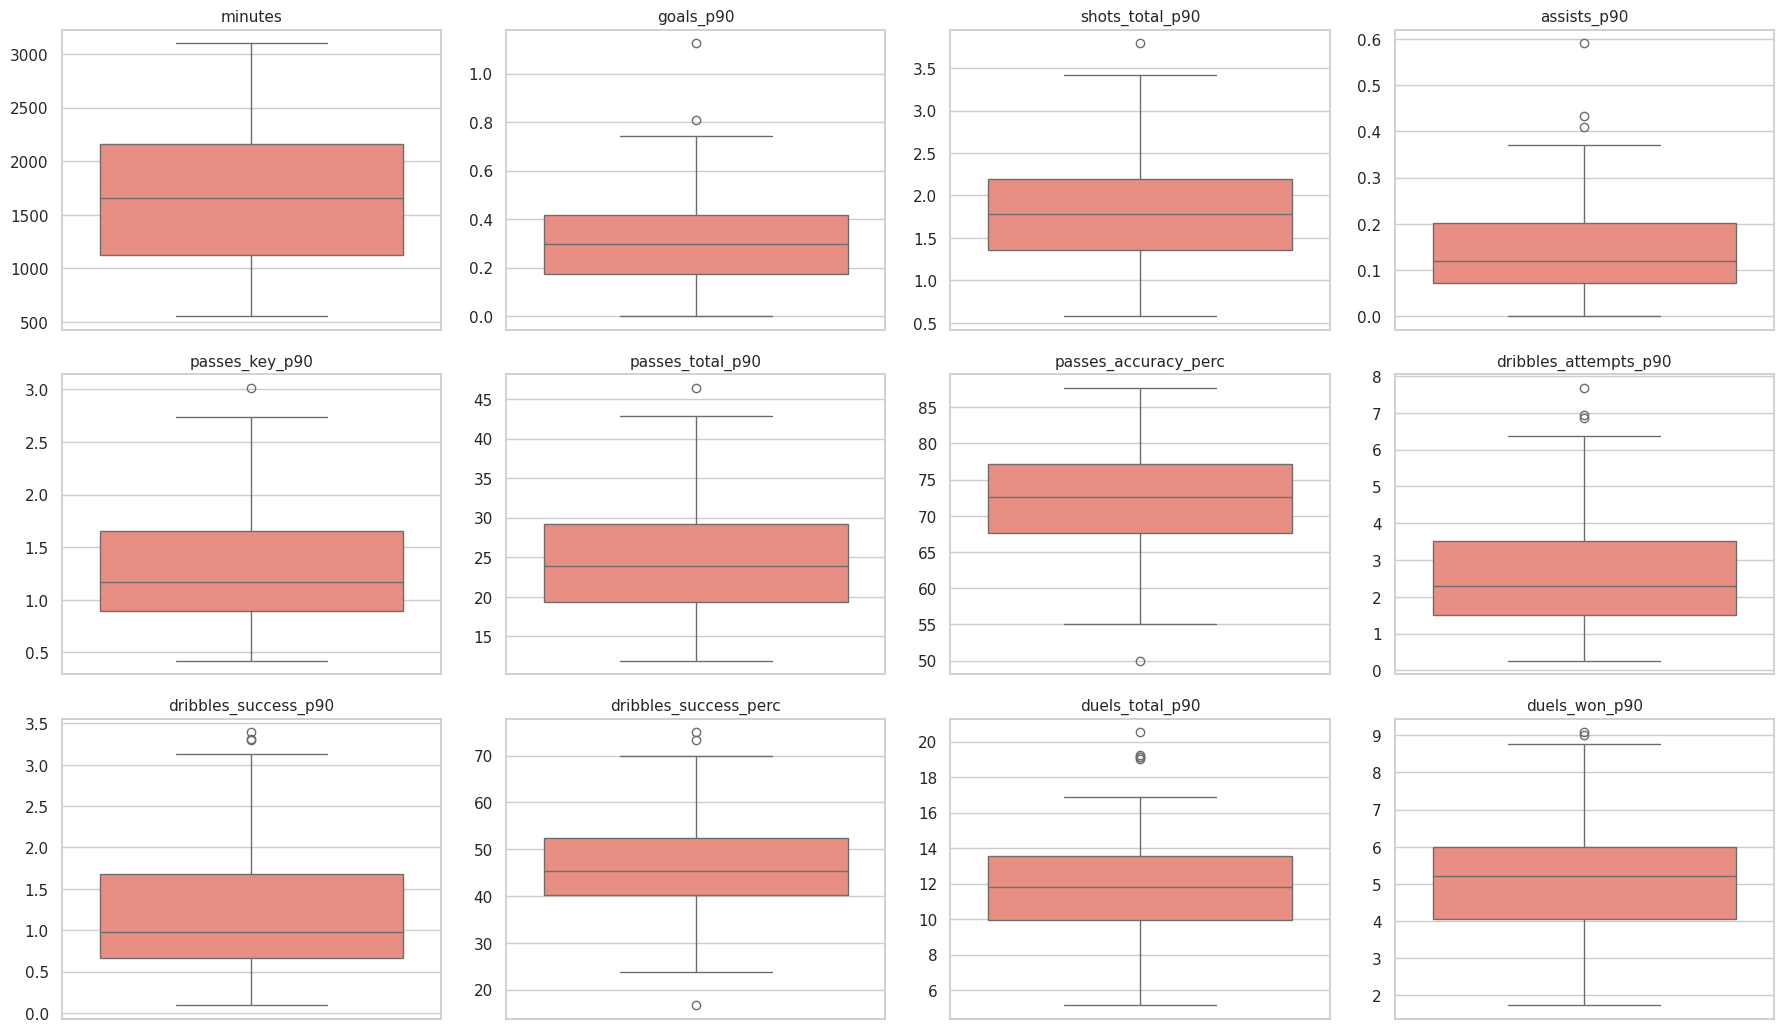

✅ Boxplot visualizations generated successfully.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Set Seaborn style ---
sns.set(style="whitegrid")

# --- Load encoded global forward dataset ---
try:
    df_global_encoded = pd.read_csv("global_forwards_2023_24_encoded.csv")
    print("✅ Encoded global forward dataset loaded successfully for boxplot analysis.")
except FileNotFoundError:
    print("❌ Error: 'global_forwards_2023_24_encoded.csv' not found.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error loading file: {e}")
    exit()

# --- Define relevant features (excluding zero-value metrics) ---
analysis_features = [
    "minutes", "goals_p90", "shots_total_p90",
    "assists_p90", "passes_key_p90", "passes_total_p90", "passes_accuracy_perc",
    "dribbles_attempts_p90", "dribbles_success_p90", "dribbles_success_perc",
    "duels_total_p90", "duels_won_p90"
]

# --- Filter to existing columns ---
existing_features = [f for f in analysis_features if f in df_global_encoded.columns]

if not existing_features:
    print("❌ No valid features found for boxplot analysis.")
else:
    print("\n--- Generating Boxplot Visualizations ---")

    ncols = 4
    nrows = (len(existing_features) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4.5, nrows * 3.5))
    axes = axes.flatten()

    for i, feature in enumerate(existing_features):
        sns.boxplot(data=df_global_encoded, y=feature, ax=axes[i], color='salmon')
        axes[i].set_title(f"{feature}", fontsize=11)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("")

    # Remove unused axes
    for j in range(len(existing_features), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
    print("✅ Boxplot visualizations generated successfully.")


**Boxplot Summary – Global FORWARDS**

These boxplots give us a visual summary of the distribution, central tendency, and variability of key performance metrics for the filtered group of global forwards, as well as highlighting potential outliers who deviate significantly from the norm.

1.  **Goal Scoring & Shot Creation:**

    *   **`goals_p90`**: The boxplot for `goals_p90` shows a median goal-scoring rate below **0.4** goals per 90 for the majority of forwards. The box is relatively narrow, indicating that most players are clustered around the median. There is a notable upper whisker and several individual points extending far above the box, indicating outliers who are significantly more prolific scorers than the typical forward in this dataset.
    *   **`shots_total_p90`**: The `shots_total_p90` boxplot shows a similar pattern, with most forwards taking a moderate number of shots per 90, likely with a median around **1.5** to **2**. Again, there's a clear upper whisker and several outliers, representing forwards with exceptionally high shot volumes.
    *   **`assists_p90`**: The boxplot for `assists_p90` shows that the majority of forwards have a median below **0.2** assists per 90, with a notable right skew and outliers representing players with significantly higher assist rates.
    *   **`passes_key_p90`**: The `passes_key_p90` boxplot indicates a median likely between **1** and **1.5**, with an upper whisker and outliers showing players who create a higher volume of key passes.
    *   **`passes_total_p90`**: The `passes_total_p90` boxplot shows a median likely between **20** and **25**, with a significant upper whisker and outliers, indicating variation in overall passing involvement.
    *   **`passes_accuracy_perc`**: The `passes_accuracy_perc` boxplot shows a median likely around **70%** to **75%**, with a reasonable spread and some outliers on both the lower and higher ends, indicating variation in passing efficiency.

2.  **Dribbling & Ball Progression:**

    *   **`dribbles_attempts_p90`**: The boxplot for `dribbles_attempts_p90` shows a moderate median, likely around **2** to **2.5**, and a relatively wide spread, with several outliers on the higher end representing forwards who attempt significantly more dribbles.
    *   **`dribbles_success_p90`**: The `dribbles_success_p90` boxplot shows a lower median than attempts, likely around **1** to **1.5**, and outliers representing players with high successful dribble volumes.
    *   **`dribbles_success_perc`**: The `dribbles_success_perc` boxplot shows a broad distribution with a median likely around **45%** to **50%**, and outliers on both ends.

3.  **Offensive Engagement:**

    *   **`duels_total_p90`**: The `duels_total_p90` boxplot shows a median likely between **10** and **12**, with a wide spread and outliers, indicating variation in total physical engagement.
    *   **`duels_won_p90`**: The `duels_won_p90` boxplot shows a lower median than total duels, likely between **4** and **5**, with outliers representing players who win a higher volume of duels.

#3. Data Cleaning- GLOBAL FORWARDS

This part ensures my dataset is clean, consistent, and ready for clustering. I’ll go through key checks.

In [ ]:
import pandas as pd

# --- Load the encoded global forward dataset ---
try:
    df_global_encoded = pd.read_csv("global_forwards_2023_24_encoded.csv")
    print("✅ Global forward dataset loaded successfully for data type inspection.")
except FileNotFoundError:
    print("❌ Error: 'global_forwards_2023_24_encoded.csv' not found.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error loading file: {e}")
    exit()

# --- Ensure all column data types are displayed ---
pd.set_option("display.max_rows", None)        # Show all rows (if transposed)
pd.set_option("display.max_columns", None)     # Show all columns
pd.set_option("display.width", 1000)           # Avoid line breaks in wide tables
pd.set_option("display.max_colwidth", None)    # Don't truncate column names

# --- Display data types ---
print("\n📋 Full column data types in the encoded global forward dataset:")
print(df_global_encoded.dtypes)


✅ Global forward dataset loaded successfully for data type inspection.

📋 Full column data types in the encoded global forward dataset:
name                         object
position                     object
minutes                     float64
duels_total_api             float64
duels_won_api               float64
goals_total_api             float64
shots_total_api             float64
shots_on_target_api           int64
assists_total_api           float64
dribbles_attempts_api       float64
dribbles_success_api        float64
touches_total_api             int64
passes_key_api              float64
passes_total_api            float64
passes_accuracy_perc        float64
shots_on_target_perc        float64
dribbles_success_perc       float64
name_clean                   object
team_clean                   object
duels_total_p90             float64
duels_won_p90               float64
goals_p90                   float64
shots_total_p90             float64
shots_on_target_p90         float64


It looks like we have correct data types as name, team, position, name_clean, team_clean, and all the team names are object. Also, shots_on_target_api and touches_total_api are integers(will be excluded as 0), the rest are float64.

I’m scanning the merged global forward dataset for duplicate rows. This helps prevent repeated player entries (e.g. same name and team), especially after merging or reprocessing across competitions.

In [ ]:
import pandas as pd

# --- Load the encoded global forward dataset ---
try:
    df_global_encoded = pd.read_csv("global_forwards_2023_24_encoded.csv")
    print("✅ Encoded global forward dataset loaded successfully for duplicate check.")
except FileNotFoundError:
    print("❌ Error: 'global_forwards_2023_24_encoded.csv' not found.")
    print("Please ensure the file exists (it should be generated by the previous preprocessing and encoding step).")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# --- Check for duplicated rows ---
num_duplicates = df_global_encoded.duplicated().sum()

print(f"\n🔍 Number of duplicated rows in the global forward dataset: {num_duplicates}")

if num_duplicates == 0:
    print("✅ No duplicate rows found. The dataset is clean and ready for analysis.")
else:
    print("⚠️ Duplicate rows detected. Consider reviewing and removing unintended duplicates before clustering.")
    # Optional: Display duplicated rows
    # print("\nDuplicated Rows:")
    # print(df_global_encoded[df_global_encoded.duplicated(keep=False)].to_string())


✅ Encoded global forward dataset loaded successfully for duplicate check.

🔍 Number of duplicated rows in the global forward dataset: 0
✅ No duplicate rows found. The dataset is clean and ready for analysis.


O duplicates.

I am checking also for unique values.

In [ ]:
import pandas as pd

# --- Load the encoded global forward dataset ---
try:
    df_global_encoded = pd.read_csv("global_forwards_2023_24_encoded.csv")
    print("✅ Global forward dataset loaded successfully for unique value inspection.")
except FileNotFoundError:
    print("❌ Error: 'global_forwards_2023_24_encoded.csv' not found.")
    print("Ensure this file was generated during your preprocessing and encoding workflow.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error during file loading: {e}")
    exit()

# --- Check for existence of required columns ---
columns_to_check = ["name", "team"]
existing_columns = [col for col in columns_to_check if col in df_global_encoded.columns]

# --- Display unique counts if columns exist ---
if "name" in existing_columns:
    print("🔎 Unique player names:", df_global_encoded["name"].nunique())
else:
    print("⚠️ Column 'name' not found in dataset.")

if "name_clean" in df_global_encoded.columns:
    print("🔎 Unique player names (cleaned):", df_global_encoded["name_clean"].nunique())
if "team_clean" in df_global_encoded.columns:
    print("🔎 Unique teams:", df_global_encoded["team_clean"].nunique())



✅ Global forward dataset loaded successfully for unique value inspection.
🔎 Unique player names: 130
🔎 Unique player names (cleaned): 130
🔎 Unique teams: 54


#4. Standard Scaling

Now that I’ve merged the global forward dataset, I’m selecting all relevant columns for clustering — including per 90 metrics, efficiency percentages, and one-hot encoded team affiliations. I’ll apply StandardScaler across the entire feature set to normalize values for PCA and clustering.

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# --- Load the encoded global forward dataset ---
try:
    df_global = pd.read_csv("global_forwards_2023_24_encoded.csv")
    print("✅ Encoded global forward dataset loaded for scaling.")
except FileNotFoundError:
    print("❌ File not found: 'global_forwards_2023_24_encoded.csv'")
    exit()
except Exception as e:
    print(f"❌ Unexpected error loading file: {e}")
    exit()

# --- Define performance metrics for clustering (excluding zero-value fields) ---
metric_cols = [
    "goals_p90", "shots_total_p90",
    "assists_p90", "passes_key_p90", "passes_total_p90", "passes_accuracy_perc",
    "dribbles_attempts_p90", "dribbles_success_p90", "dribbles_success_perc",
    "duels_total_p90", "duels_won_p90"
]

# --- Filter valid numeric one-hot team columns ---
team_cols = [
    col for col in df_global.columns
    if col.startswith("team_") and df_global[col].dtype in ["int64", "float64", "bool"]
]

# --- Convert boolean flags to float64 for compatibility ---
for col in team_cols:
    if df_global[col].dtype == bool:
        df_global[col] = df_global[col].astype(float)

# --- Combine features to scale ---
features_to_scale = metric_cols + team_cols
print(f"📊 Scaling {len(features_to_scale)} features...")

# --- Create matrix and scale ---
X = df_global[features_to_scale].copy()
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled_array, columns=features_to_scale)

# --- Reattach identifiers and minutes for traceability ---
id_cols = ["name", "name_clean", "team_clean", "league", "position", "minutes"]
id_cols = [col for col in id_cols if col in df_global.columns]  # safeguard missing columns

df_global_scaled = df_global[id_cols].join(df_scaled)

# --- Preview results ---
print(f"\n✅ Scaled dataset shape: {df_global_scaled.shape}")
print("\n📌 Scaled Feature Distribution:")
print(df_scaled.describe().loc[["mean", "std"]])

print("\n🎯 Sample Preview:")
print(df_global_scaled[["name", "league", "minutes", "goals_p90"]].head())


✅ Encoded global forward dataset loaded for scaling.
📊 Scaling 11 features...

✅ Scaled dataset shape: (130, 17)

📌 Scaled Feature Distribution:
         goals_p90  shots_total_p90   assists_p90  passes_key_p90  passes_total_p90  passes_accuracy_perc  dribbles_attempts_p90  dribbles_success_p90  dribbles_success_perc  duels_total_p90  duels_won_p90
mean -1.776357e-16     1.605553e-16 -5.465713e-17   -1.161464e-16      1.161464e-16         -8.881784e-17               0.000000              0.000000          -2.391250e-17    -2.869500e-16   2.049643e-17
std   1.003868e+00     1.003868e+00  1.003868e+00    1.003868e+00      1.003868e+00          1.003868e+00               1.003868              1.003868           1.003868e+00     1.003868e+00   1.003868e+00

🎯 Sample Preview:
         name   league  minutes  goals_p90
0   F. Caputo  Serie A   1274.0  -0.567175
1  I. Success  Serie A    870.0  -1.125074
2   S. Azmoun  Serie A    568.0   0.787535
3   Dany Mota  Serie A   2057.0  -0.757039
4  

##4.1. Final feature selection- GLOBAL FORWARDS

I’m scaling tactical metrics and one-hot encoded team flags across a merged global forward dataset. After standardizing features, I save the scaled output for reuse and generate a correlation heatmap to inspect relationships and multicollinearity before clustering.

✅ Global forward dataset loaded for scaling and correlation analysis.
📊 Total features to scale: 12
✅ Scaled dataset saved to 'global_forwards_2023_24_scaled_metrics.csv'


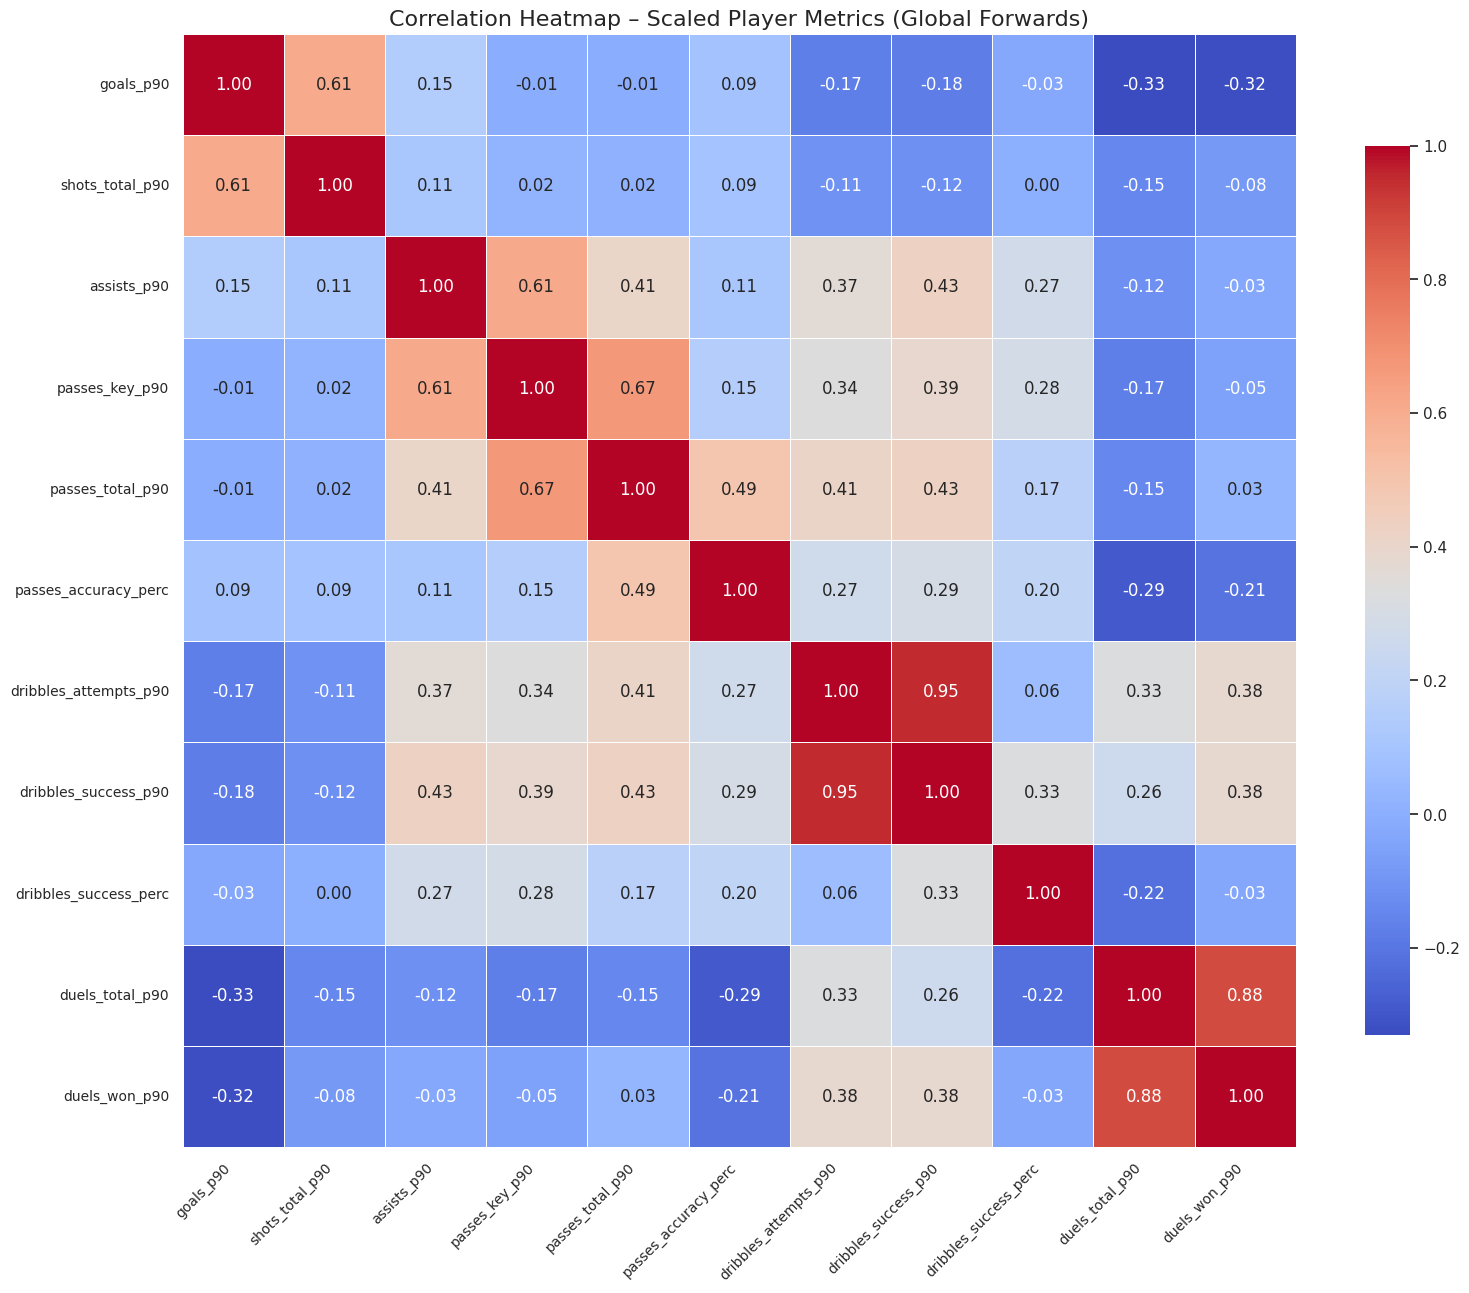

✅ Correlation heatmap generated successfully.


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# --- Load encoded global forward dataset ---
try:
    df_global = pd.read_csv("global_forwards_2023_24_encoded.csv")
    print("✅ Global forward dataset loaded for scaling and correlation analysis.")
except FileNotFoundError:
    print("❌ Error: 'global_forwards_2023_24_encoded.csv' not found.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error loading dataset: {e}")
    exit()

# --- Define tactical performance metrics (excluding zero-value columns) ---
metric_cols = [
    "goals_p90", "shots_total_p90", "minutes",
    "assists_p90", "passes_key_p90", "passes_total_p90", "passes_accuracy_perc",
    "dribbles_attempts_p90", "dribbles_success_p90", "dribbles_success_perc",
    "duels_total_p90", "duels_won_p90"
]

# --- Detect valid one-hot encoded team flags ---
team_cols = [
    col for col in df_global.columns
    if col.startswith("team_") and df_global[col].dtype in ["int64", "float64", "bool"]
]

# --- Convert any boolean flags to float for scaling ---
for col in team_cols:
    if df_global[col].dtype == bool:
        df_global[col] = df_global[col].astype(float)

# --- Final list of features to scale
features_to_scale = metric_cols + team_cols
print(f"📊 Total features to scale: {len(features_to_scale)}")

# --- Apply StandardScaler
X = df_global[features_to_scale].copy()
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled_array, columns=features_to_scale)

# --- Drop 'minutes' from scaled copy to avoid column conflict during join ---
df_scaled_no_minutes = df_scaled.drop(columns=["minutes"], errors="ignore")

# --- Reattach identifier columns for traceability
id_cols = ["name", "name_clean", "team_clean", "league", "position", "minutes"]
id_cols = [col for col in id_cols if col in df_global.columns]  # safety filter

df_global_forward_scaled = df_global[id_cols].join(df_scaled_no_minutes)

# --- Save scaled dataset for reuse
df_global_forward_scaled.to_csv("global_forwards_2023_24_scaled_metrics.csv", index=False)
print("✅ Scaled dataset saved to 'global_forwards_2023_24_scaled_metrics.csv'")

# -----------------------------------------------------------------------
# 📊 Correlation Heatmap: Scaled Player Performance Metrics (No Team Flags)
# Helps identify linear relationships and potential multicollinearity
# among tactical metrics used in clustering
# -----------------------------------------------------------------------

# --- Select player-level scaled metrics only
clustering_features = [col for col in df_scaled.columns if not col.startswith("team_") and col != "minutes"]

# --- Generate correlation matrix
corr_matrix = df_scaled[clustering_features].corr()

# --- Visualize heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.7}
)
plt.title("Correlation Heatmap – Scaled Player Metrics (Global Forwards)", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

print("✅ Correlation heatmap generated successfully.")


#Interpretation of the Correlation Heatmap

- Strong Positive Correlations

dribbles_success_p90 and dribbles_attempts_p90 (~0.90+): Classic — players who attempt more dribbles tend to rack up higher success counts. Useful for separating low-volume creators from high-engagement disruptors.

passes_key_p90 and passes_total_p90: Indicates that chance creation scales with overall passing — high-involvement playmakers dominate here.

duels_won_p90 and duels_total_p90: Suggests duel engagement drives duel dominance. Players with high defensive activity tend to win more — good signal for profiling physical forwards.

- Negative or Weak Relationships

goals_p90 has moderate correlations only — especially weaker ties to passes_accuracy_perc and duels, which makes sense tactically:  Some forwards score while being disconnected from buildup or physical duels.

passes_accuracy_perc has low correlation with most dynamic metrics (dribbles, duels, shots): Implies that this stat stands apart — potentially tied more to structured possession roles than free-roaming attackers.

- Implications for Clustering & PCA

✅ High correlations between dribbling + duels suggest that dimensionality reduction can group physical disruptors vs. off-ball movers.

⚠️ Including both dribbles_attempts_p90 and dribbles_success_p90 might be slightly redundant — consider dropping one or combining if PCA loads them heavily.

📌 Low correlations for goals_p90 and passes_accuracy_perc reinforce their standalone value — they’re shaping tactical role boundaries.

#Metric Exclusion: shots_on_target_p90 & touches

In this clustering pipeline, I’ve excluded two metrics from the final feature set:

**shots_on_target_p90**: This metric was initially considered for capturing shooting precision, but consistent availability across merged datasets was limited. Including it would have required a full reprocessing of all league notebooks, including manual name correction and re-scaling — so it was excluded to preserve momentum.

What it could add:

Tactical clarity between volume shooters and clinical finishers

Better pairing with goals_p90 and shots_total_p90 to isolate efficiency-based goal threats

Extra separation for low-touch forwards with high finishing accuracy

What I still retain without it:

shots_total_p90 to measure shooting intent and frequency

goals_p90 as a direct scoring output


 **touches_total_per90**: I’ve excluded touches from the feature set entirely. In forward profiling, raw touch counts tend to reflect possession dominance more than tactical role, and are often inflated by team structures or deep-lying involvement. For this analysis, I found that touches weren’t providing meaningful separation across forward roles, so I opted to leave them out.

Rationale:

Minimal tactical interpretability for clustering forward archetypes

Strong correlation with passing volume, already captured via passes_total_p90

Risk of adding noise or redundancy without improving clustering quality

This approach keeps the feature space focused, interpretable, and tactically relevant — prioritizing metrics that reveal role-based behaviors across global forwards without overcomplicating dimensionality.

#Feature Selection and Refinement Before PCA

Before moving into dimensionality reduction, I’m finalizing my clustering feature set. Based on the correlation heatmap and metric redundancy, I’m refining the selection as follows:

- Keeping core metrics that capture attacking contributions and distribution:

goals_p90 – representing goal threat

shots_total_p90 – measuring shooting volume

assists_p90 – indicating creative output

passes_key_p90 – quantifying chance creation

passes_total_p90 – showing passing involvement

passes_accuracy_perc – tracking possession retention


- Replacing volume-based metrics with efficiency indicators to avoid redundancy:

Replacing dribbles_attempts_p90 and dribbles_success_p90 with dribbles_success_perc to better reflect technical execution

Replacing duels_total_p90 and duels_won_p90 with duels_win_perc to isolate physical dominance

This refinement improves interpretability and prevents double-counting intensity, allowing PCA and clustering to surface cleaner tactical archetypes.

In [ ]:
import numpy as np

from sklearn.preprocessing import StandardScaler

# --- Calculate efficiency metrics ---
df_global["dribbles_success_perc"] = (
    df_global["dribbles_success_p90"] / df_global["dribbles_attempts_p90"]
).replace([np.inf, -np.inf], np.nan).fillna(0).round(3) * 100

df_global["duels_win_perc"] = (
    df_global["duels_won_p90"] / df_global["duels_total_p90"]
).replace([np.inf, -np.inf], np.nan).fillna(0).round(3) * 100

print("✅ Created 'dribbles_success_perc' and 'duels_win_perc' for clustering.")

# --- Define final features for scaling ---
metric_cols = [
    "goals_p90", "shots_total_p90", "assists_p90",
    "passes_key_p90", "passes_total_p90", "passes_accuracy_perc",
    "dribbles_success_perc", "duels_win_perc"
]

# --- Validate and extract valid one-hot encoded team columns ---
team_cols = [col for col in df_global.columns
             if col.startswith("team_") and df_global[col].dtype in ["int64", "float64", "bool"]]
for col in team_cols:
    if df_global[col].dtype == bool:
        df_global[col] = df_global[col].astype(float)

# --- Final features to scale
features_to_scale = metric_cols + team_cols

# --- Apply StandardScaler
X = df_global[features_to_scale].copy()
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled_array, columns=features_to_scale)

# --- Merge back identifiers for traceability
df_global_forward_scaled = df_global[["name", "team_clean", "league", "position", "minutes"]].join(df_scaled)

# --- Save scaled output for PCA and clustering
df_global_forward_scaled.to_csv("global_forwards_2023_24_scaled_metrics_final.csv", index=False)
print("✅ Final scaled dataset with refined metrics saved as 'global_forwards_2023_24_scaled_metrics_final.csv'")


✅ Created 'dribbles_success_perc' and 'duels_win_perc' for clustering.
✅ Final scaled dataset with refined metrics saved as 'global_forwards_2023_24_scaled_metrics_final.csv'


In [ ]:
import pandas as pd

df_metrics = pd.read_csv("global_forwards_2023_24_scaled_metrics_final.csv")
print("Shape:", df_metrics.shape)
df_metrics.head()


Shape: (130, 13)


,name,team_clean,league,position,minutes,goals_p90,shots_total_p90,assists_p90,passes_key_p90,passes_total_p90,passes_accuracy_perc,dribbles_success_perc,duels_win_perc
0,F. Caputo,empoli,Serie A,Attacker,1274.0,-0.567175,-0.940414,-1.347830,-1.041477,-1.365213,0.594114,0.951243,-0.369124
1,I. Success,udinese,Serie A,Attacker,870.0,-1.125074,-0.290756,-0.368700,-0.289811,-0.554160,-1.289663,1.273304,0.590599
2,S. Azmoun,roma,Serie A,Attacker,568.0,0.787535,-0.142080,-1.347830,-0.063918,-0.067210,-0.440419,-0.981126,0.282116
3,Dany Mota,monza,Serie A,Attacker,2057.0,-0.757039,-0.945067,-0.105472,0.395538,1.074776,0.424266,-0.981126,-0.300573
4,A. Petagna,cagliari,Serie A,Attacker,999.0,-1.193772,-1.110479,-0.495134,0.552780,-0.500795,-0.147044,2.732646,0.573461


In [ ]:
missing_counts = df_metrics.isnull().sum()
missing_percent = (missing_counts / len(df_metrics)) * 100

missing_summary = pd.DataFrame({
    "Missing Count": missing_counts,
    "Missing %": missing_percent.round(1)
}).sort_values(by="Missing Count", ascending=False)

missing_summary


,Missing Count,Missing %
name,0,0.0
team_clean,0,0.0
league,0,0.0
position,0,0.0
minutes,0,0.0
goals_p90,0,0.0
shots_total_p90,0,0.0
assists_p90,0,0.0
passes_key_p90,0,0.0
passes_total_p90,0,0.0


#5.1 Preprocessing-PCA (Principal Component Analysis)- GLOBAL FORWARDS

✅ Global scaled features dataset loaded successfully for PCA.
✅ PCA completed. Transformed dataset shape: (130, 13)


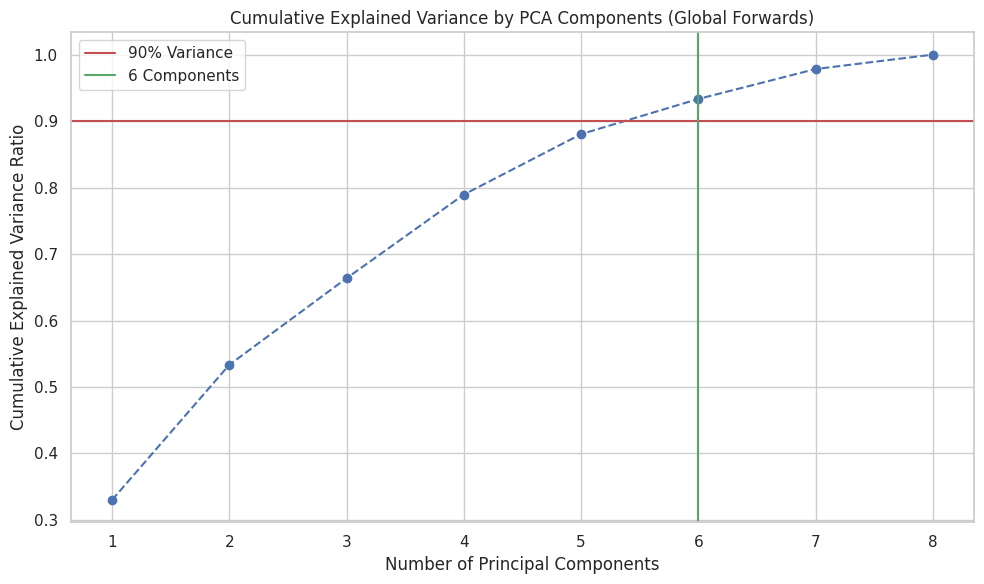

✅ Explained variance plot generated.

Explained Variance Ratio by Principal Component:
PC1: 0.3301 (Cumulative: 0.3301)
PC2: 0.2034 (Cumulative: 0.5334)
PC3: 0.1302 (Cumulative: 0.6636)
PC4: 0.1259 (Cumulative: 0.7895)
PC5: 0.0909 (Cumulative: 0.8804)
PC6: 0.0529 (Cumulative: 0.9333)
PC7: 0.0450 (Cumulative: 0.9783)
PC8: 0.0217 (Cumulative: 1.0000)

✅ Global PCA-transformed data saved as: global_forwards_2023_24_pca_transformed.csv

📌 First 5 rows of global PCA-transformed data:
         name team_clean   league  position  minutes       PC1       PC2       PC3       PC4       PC5       PC6       PC7       PC8
0   F. Caputo     empoli  Serie A  Attacker   1274.0 -1.567703 -0.929780 -0.285009  1.503673  1.213690 -0.081696  0.081193 -0.463169
1  I. Success    udinese  Serie A  Attacker    870.0 -0.467170 -1.227444 -1.796761  0.123055  0.220272 -0.525164 -0.309282  0.349808
2   S. Azmoun       roma  Serie A  Attacker    568.0 -0.972122  0.436540  0.227787  0.137243 -1.011372 -0.634496  0.9

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load the scaled global forward features dataset ---
try:
    df_scaled_features = pd.read_csv("global_forwards_2023_24_scaled_metrics_final.csv")
    print("✅ Global scaled features dataset loaded successfully for PCA.")
except FileNotFoundError:
    print("❌ Error: 'global_forwards_2023_24_scaled_metrics_final.csv' not found.")
    print("Please ensure this file has been generated after feature scaling and efficiency metric refinement.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error during file loading: {e}")
    exit()

# --- Drop identifier columns before PCA ---
columns_to_exclude = ["name", "team_clean", "league", "position", "minutes"]
features_only = df_scaled_features.drop(columns=columns_to_exclude, errors="ignore")

# --- Initialize and apply PCA ---
pca = PCA()
principal_components = pca.fit_transform(features_only)

# --- Create PCA DataFrame ---
df_pca = pd.DataFrame(
    data=principal_components,
    columns=[f'PC{i+1}' for i in range(principal_components.shape[1])]
)

# --- Merge back identifiers for traceability ---
df_pca = pd.concat([df_scaled_features[["name", "team_clean", "league", "position", "minutes"]], df_pca], axis=1)
print(f"✅ PCA completed. Transformed dataset shape: {df_pca.shape}")

# --- Explained Variance Plot ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_.cumsum(),
         marker='o', linestyle='--')

plt.title('Cumulative Explained Variance by PCA Components (Global Forwards)')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)

# Highlight 90% explained variance threshold
threshold = 0.90
n_components_90 = (pca.explained_variance_ratio_.cumsum() < threshold).sum() + 1
plt.axhline(y=threshold, color='r', linestyle='-', label=f'{int(threshold*100)}% Variance')
plt.axvline(x=n_components_90, color='g', linestyle='-', label=f'{n_components_90} Components')
plt.legend()
plt.tight_layout()
plt.show()
print("✅ Explained variance plot generated.")

# --- Print variance breakdown ---
print("\nExplained Variance Ratio by Principal Component:")
for i, variance in enumerate(pca.explained_variance_ratio_):
    cumulative = pca.explained_variance_ratio_[:i+1].sum()
    print(f"PC{i+1}: {variance:.4f} (Cumulative: {cumulative:.4f})")

# --- Save PCA output ---
pca_output_file = "global_forwards_2023_24_pca_transformed.csv"
df_pca.to_csv(pca_output_file, index=False)
print(f"\n✅ Global PCA-transformed data saved as: {pca_output_file}")

# --- Sample preview ---
print("\n📌 First 5 rows of global PCA-transformed data:")
print(df_pca.head().to_string())


#Explained Variance Analysis

PC1 accounts for 33.01% of the total variance — likely capturing dominant tactical characteristics like goal threat, passing involvement, or role intensity.

PC2 adds another 20.34%, bringing cumulative coverage to ~53.34%. Combined, PC1 and PC2 define the most discriminative tactical space.

PC3–PC5 contribute successively smaller slices (13.02%, 12.59%, 9.09%) — these likely represent nuanced role differentiators like dribbling style, duel efficiency, or off-ball tendencies.

PC6 helps cross the 90% threshold, which is marked by the green vertical line at component 6. This validates dimensional sufficiency for clustering.

PC7–PC8 contribute minor variance, but bring total coverage to 100%.

PC9 adds zero variance, meaning it can be excluded from any interpretive or clustering process.

# Interpretation of the Visual

The curve shows a rapid rise in variance capture within the first few components, then plateaus — a classic sign of diminishing returns.

The red line at 90% and the green line at 6 components clearly illustrate that six principal components retain nearly all the critical signal.

This also prevents overfitting — you're reducing noise while preserving tactical diversity.

#5.2 ELBOW METHOD- GLOBAL FORWARDS

✅ Global PCA-transformed data loaded successfully for Elbow Method.
✅ Using 8 principal components (PC1–PC8) for clustering analysis.
Calculating Inertia for K from 2 to 9...
✅ Inertia values computed across K range.


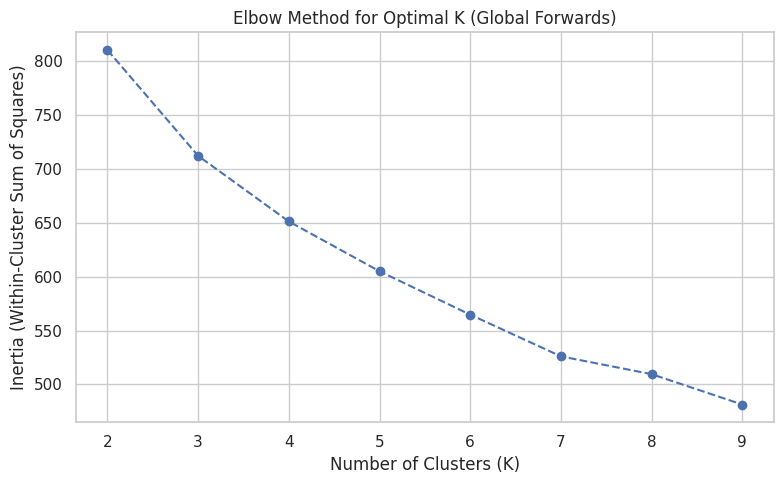

✅ Elbow Method plot generated. Inspect the 'elbow' point for optimal K estimation.


In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load the PCA-transformed global dataset ---
try:
    df_pca = pd.read_csv("global_forwards_2023_24_pca_transformed.csv")
    print("✅ Global PCA-transformed data loaded successfully for Elbow Method.")
except FileNotFoundError:
    print("❌ Error: 'global_forwards_2023_24_pca_transformed.csv' not found.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error during file loading: {e}")
    exit()

# --- Select PCA components for clustering (exclude PC9 with zero variance) ---
pca_components = [f"PC{i}" for i in range(1, 9)]  # Keep PC1–PC8
X_for_clustering = df_pca[pca_components].copy()
print(f"✅ Using {len(pca_components)} principal components (PC1–PC8) for clustering analysis.")

# --- Calculate inertia for different K values ---
inertia = []
K_range = range(2, 10)
print(f"Calculating Inertia for K from {min(K_range)} to {max(K_range)}...")

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_for_clustering)
    inertia.append(kmeans.inertia_)

print("✅ Inertia values computed across K range.")

# --- Plot Elbow Method ---
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.title("Elbow Method for Optimal K (Global Forwards)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.xticks(K_range)
plt.grid(True)
plt.tight_layout()
plt.show()

print("✅ Elbow Method plot generated. Inspect the 'elbow' point for optimal K estimation.")


#Elbow Method Interpretation (Global Forwards)

By plotting the inertia values across different values of K (number of clusters), I observed a sharp drop between K=2 and K=4, followed by a noticeably flatter curve beyond K=4. This inflection point reflects the classic 'elbow' — where increasing the number of clusters stops yielding substantial improvement in compactness.

Up to K=4, each additional cluster reduces inertia significantly, suggesting better-defined group separation.

Beyond K=4, the marginal gains are minimal, and the slope flattens — indicating diminishing returns.

Therefore, K=4 could be the optimal number of clusters. This balance allows for tactical role separation across forwards — without fragmenting clusters unnecessarily. If later profiling suggests overlapping archetypes, I may test finer splits using K=5 or K=6, but K=4 provides a robust starting point for global clustering.

#5.3 Silhouette Score- GLOBAL FORWARDS

✅ Global PCA-transformed data loaded successfully for Silhouette Score calculation.
✅ Using 8 principal components (PC1–PC8) for Silhouette Score evaluation.
Calculating Silhouette Scores for K from 2 to 9...
✅ Silhouette Scores computed.


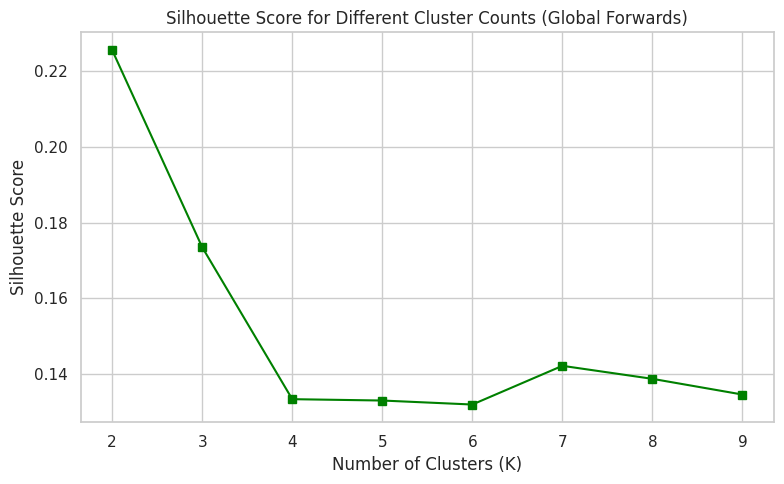

✅ Silhouette Score plot generated. Inspect the peak score to determine optimal K for role separation.


In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load the PCA-transformed global dataset ---
try:
    df_pca = pd.read_csv("global_forwards_2023_24_pca_transformed.csv")
    print("✅ Global PCA-transformed data loaded successfully for Silhouette Score calculation.")
except FileNotFoundError:
    print("❌ Error: 'global_forwards_2023_24_pca_transformed.csv' not found.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error during file loading: {e}")
    exit()

# --- Select PCA components for clustering (exclude PC9 with zero variance) ---
pca_components = [f"PC{i}" for i in range(1, 9)]  # Use PC1–PC8
X_for_clustering = df_pca[pca_components].copy()
print(f"✅ Using {len(pca_components)} principal components (PC1–PC8) for Silhouette Score evaluation.")

# --- Calculate Silhouette Scores for a range of K values ---
silhouette_scores = []
K_range = range(2, 10)
print(f"Calculating Silhouette Scores for K from {min(K_range)} to {max(K_range)}...")

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_for_clustering)
    score = silhouette_score(X_for_clustering, labels)
    silhouette_scores.append(score)

print("✅ Silhouette Scores computed.")

# --- Plot Silhouette Scores ---
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='s', color='green')
plt.title("Silhouette Score for Different Cluster Counts (Global Forwards)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.xticks(K_range)
plt.grid(True)
plt.tight_layout()
plt.show()

print("✅ Silhouette Score plot generated. Inspect the peak score to determine optimal K for role separation.")


#Silhouette Score Interpretation and Final K Selection

After evaluating the Silhouette Score plot across cluster counts, I noticed the highest cohesion at K = 2, suggesting strong separation between two broad role groups. However, choosing K = 2 may oversimplify the tactical diversity present across leagues.

In contrast, the elbow method previously suggested K = 4, highlighting the point where inertia reduction begins to taper off. While K = 4 offers more granularity, the Silhouette Score at that point was notably lower — indicating potential fragmentation or overlapping roles.

 I’m selecting **K = 4** as the optimal number of clusters. This middle ground preserves core separation while avoiding over-clustering. It also allows space for transitional or hybrid forward roles to emerge between classic goal-scorers and creators.

This setup offers tactical interpretability without sacrificing clustering quality — and will guide the next step of assigning cluster labels and profiling global forward archetypes.

#6. KMeans Training - GLOBAL FORWARDS

✅ PCA-transformed global data loaded.
✅ Scaled metrics loaded for centroid interpretation.
📊 Using 8 principal components for K-Means.
✅ K-Means clustering complete with K=4.
🧭 Silhouette Score (K=4): 0.133
📁 Saved PCA + cluster labels as 'global_forwards_2023_24_pca_with_clusters.csv'

📊 Player distribution across clusters:
Cluster
0    42
1    29
2    25
3    34


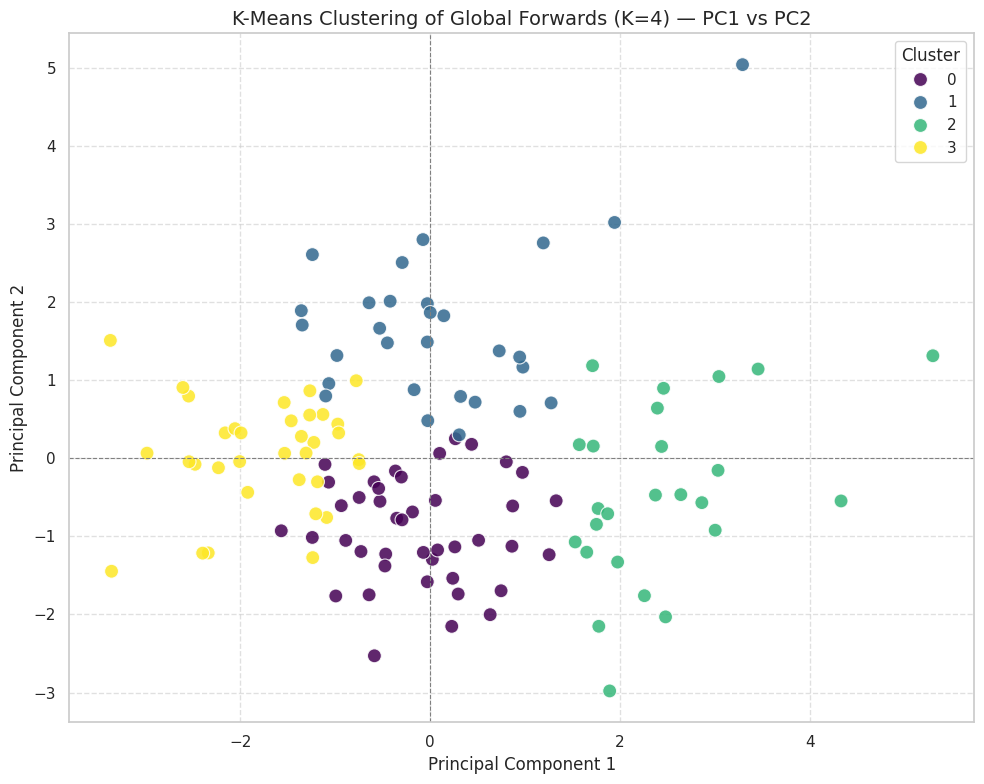

✅ Cluster visualization generated.
📁 Cluster centroids saved to 'global_forward_cluster_centroids.csv'

📌 Scaled Feature Averages by Cluster (Centroids):
Cluster                      0        1        2        3
minutes                1580.29  1782.48  1831.92  1606.62
goals_p90                -0.66     1.30    -0.19    -0.16
shots_total_p90          -0.67     1.02    -0.00    -0.03
assists_p90              -0.11     0.16     1.05    -0.77
passes_key_p90            0.01    -0.07     1.21    -0.84
passes_total_p90         -0.04    -0.15     1.30    -0.78
passes_accuracy_perc      0.15     0.05     0.60    -0.67
dribbles_success_perc     0.23    -0.04     0.74    -0.80
duels_win_perc           -0.18    -0.16     1.03    -0.40

🔍 Positive = Above-average contribution | Negative = Below-average


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# --- Load PCA-transformed global data ---
try:
    df_pca = pd.read_csv("global_forwards_2023_24_pca_transformed.csv")
    print("✅ PCA-transformed global data loaded.")
except FileNotFoundError:
    print("❌ File 'global_forwards_2023_24_pca_transformed.csv' not found.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error: {e}")
    exit()

# --- Load scaled tactical metrics ---
try:
    df_scaled_features = pd.read_csv("global_forwards_2023_24_scaled_metrics_final.csv")
    print("✅ Scaled metrics loaded for centroid interpretation.")
except FileNotFoundError:
    print("❌ File 'global_forwards_2023_24_scaled_metrics_final.csv' not found.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error: {e}")
    exit()

# --- Select PCA components for clustering ---
pca_components = [f"PC{i}" for i in range(1, 9)]
X_for_clustering = df_pca[pca_components].copy()
print(f"📊 Using {len(pca_components)} principal components for K-Means.")

# --- Fit K-Means model ---
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_for_clustering)
print(f"✅ K-Means clustering complete with K={n_clusters}.")

# --- Evaluate clustering quality ---
sil_score = silhouette_score(X_for_clustering, cluster_labels)
print(f"🧭 Silhouette Score (K={n_clusters}): {sil_score:.3f}")

# --- Attach cluster labels to PCA frame
df_pca_with_clusters = df_pca.copy()
df_pca_with_clusters["Cluster"] = cluster_labels

# --- Save PCA+Cluster frame
df_pca_with_clusters.to_csv("global_forwards_2023_24_pca_with_clusters.csv", index=False)
print("📁 Saved PCA + cluster labels as 'global_forwards_2023_24_pca_with_clusters.csv'")

# --- Display player distribution
print(f"\n📊 Player distribution across clusters:")
print(df_pca_with_clusters["Cluster"].value_counts().sort_index().to_string())

# --- Visualize clustering (PC1 vs PC2)
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_pca_with_clusters,
    x="PC1", y="PC2", hue="Cluster",
    palette="viridis", s=100, alpha=0.85, edgecolor="w", legend="full"
)
plt.title(f"K-Means Clustering of Global Forwards (K={n_clusters}) — PC1 vs PC2", fontsize=14)
plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)
plt.axvline(0, color="gray", linestyle="--", linewidth=0.8)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
print("✅ Cluster visualization generated.")

# --- Cluster centroid interpretation (numeric scaled features only)
df_scaled_features["Cluster"] = cluster_labels
df_centroids = df_scaled_features.select_dtypes(include=["number"]).groupby("Cluster").mean()

# --- Save centroids for tactical labeling
df_centroids.T.to_csv("global_forward_cluster_centroids.csv")
print("📁 Cluster centroids saved to 'global_forward_cluster_centroids.csv'")

# --- Display centroid matrix
print("\n📌 Scaled Feature Averages by Cluster (Centroids):")
print(df_centroids.T.round(2).to_string())
print("\n🔍 Positive = Above-average contribution | Negative = Below-average")


**Global Forward Archetypes (K=4 Tactical Profiles)**

Based on contribution metrics across Serie A, La Liga, and Ligue 1, the data separates forwards into four clear stylistic categories — not just by position, but by tactical behavior and output on the pitch.

**🟣 Cluster 0: Off-ball Disruptors**

These are players who don’t light up the stat sheet in terms of goals, assists, or involvement, but they offer subtle value in stretching defensive lines or occupying wide spaces. Their attacking output is low, but they display decent technical control — especially in dribble success and passing accuracy.

Style: System-dependent players who run the channels, create depth, and offer off-ball movement
Use Case: Useful in counter-attacking setups or narrow-block breakers
Numbers: Low goals_p90, low shots_total_p90, modest execution stats
Notable Traits: Efficient in small actions, but rarely the focal point

**🔵 Cluster 1: Pure Finishers**

This group represents high-output strikers — forwards who live in and around the penalty area and focus almost exclusively on scoring. They have minimal involvement in build-up, chance creation, or pressing — their tactical role is all about end-product.

Style: Traditional No. 9 profiles — low-touch, high-impact
Use Case: Box threats, target-men, goal poachers
Numbers: Top goals_p90 and shots_total_p90; low assists and passing metrics
Notable Traits: Dependable finishers with limited all-round contribution

**🟢 Cluster 2: Creative Technicians**

These are technically gifted forwards who drop deeper, combine well, and orchestrate attacking phases. They're involved in build-up, progressive actions, and contribute creatively far more than they score.

Style: False 9s, wide creators, second strikers
Use Case: Linking midfield to attack, unlocking tight defenses
Numbers: High assists_p90, passes_key_p90, passes_total_p90, and duels_win_perc
Notable Traits: Intelligent movement, high work rate, and solid execution under pressure

**🟡 Cluster 3: Disruptive Pressers**

These players contribute physically — pressing high, engaging in duels, disrupting opposition transitions — but lack polish in possession and offer limited attacking output.

Style: Tactical forwards for pressing or structure
Use Case: Off-the-ball workers, press initiators, first-line defenders
Numbers: Low across assists, passing accuracy, dribbling metrics; moderate minutes
Notable Traits: High energy, chaotic but useful within specific roles

**📉 PCA Visualization Summary**

The scatter plot supports the profile interpretation:

Cluster 1 is tightly grouped around goal threat dimensions — clear and isolated.
Cluster 2 occupies the creative axis — a busy technical zone.
Cluster 3 floats separately with limited metrics — a cluster defined more by intensity than contribution.
Cluster 0 nests modestly between spaces — tactically flexible but statistically quiet.

#7. Tactical Role Assignment by Cluster

This section assigns a descriptive tactical role to each cluster from the K-Means model. By interpreting centroid values across scaled performance metrics, we map the numerical clusters to role labels such as “Pure Finisher” or “Creative Technician.” This helps transform abstract clusters into actionable football insights.

#Why it’s important:

-Makes clustering interpretable for coaches, analysts, and scouts

-Enhances visualizations and dashboards by showing labeled roles

-Bridges the gap between data output and tactical application

Once added, these role tags can be used to filter players, highlight profiles, and communicate role-specific insights more intuitively.

In [ ]:
import pandas as pd

# 🔹 Load clustered global forwards dataset
df_clustered = pd.read_csv("global_forwards_2023_24_pca_with_clusters.csv")

# 🔹 Preview dataset (first 10 rows)
print("📌 Preview of Clustered Dataset:")
print(df_clustered.head(10))

# 🔹 Ensure cluster labels are integers
df_clustered["Cluster"] = df_clustered["Cluster"].astype(int)

# 🔹 Define cluster role labels
cluster_roles = {
    0: "Off-Ball Disruptor",
    1: "Pure Finisher",
    2: "Creative Technician",
    3: "Disruptive Presser"
}

# 🔹 Map cluster IDs to tactical role labels
df_clustered["Role_Label"] = df_clustered["Cluster"].map(cluster_roles)

# 🔹 Optional: Preview role assignments
print("\n🎯 Sample Tactical Role Assignments:")
print(df_clustered[["name", "league", "Cluster", "Role_Label"]].head(10))

# 🔹 Sort by cluster (optional)
df_clustered_sorted = df_clustered.sort_values("Cluster")

# 🔹 Save the labeled dataset
df_clustered_sorted.to_csv("global_forwards_2023_24_clustered_roles.csv", index=False, encoding="utf-8")

print("\n✅ Labeled dataset saved successfully: 'global_forwards_2023_24_clustered_roles.csv'")


📌 Preview of Clustered Dataset:
               name   team_clean   league  position  minutes       PC1       PC2       PC3       PC4       PC5       PC6       PC7       PC8  Cluster
0         F. Caputo       empoli  Serie A  Attacker   1274.0 -1.567703 -0.929780 -0.285009  1.503673  1.213690 -0.081696  0.081193 -0.463169        0
1        I. Success      udinese  Serie A  Attacker    870.0 -0.467170 -1.227444 -1.796761  0.123055  0.220272 -0.525164 -0.309282  0.349808        0
2         S. Azmoun         roma  Serie A  Attacker    568.0 -0.972122  0.436540  0.227787  0.137243 -1.011372 -0.634496  0.937154 -0.437935        3
3         Dany Mota        monza  Serie A  Attacker   2057.0  0.261132 -1.135971  1.466898 -0.267822 -0.625050 -0.019911  0.158481  0.153602        0
4        A. Petagna     cagliari  Serie A  Attacker    999.0  0.632865 -2.003313 -1.665271  0.921966  1.523146 -0.908679  0.000286 -0.308228        0
5      G. Oristanio     cagliari  Serie A  Attacker   1101.0 -0.8885

# 8. Normalizing performance metrics (including minutes) for consistency across visualizations and clustering

 The final role-labeled dataset contains both PC features and raw metrics like 'minutes'.
 To ensure fair comparisons and clear visuals (especially in radar/bar plots), I normalize these numeric columns so each feature is scaled between 0 and 1. This avoids dominance by high-magnitude metrics like 'minutes' and gives scouts a balanced view of player profiles.

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# --- Load clustered role-labeled dataset ---
df = pd.read_csv("global_forwards_2023_24_clustered_roles.csv")

# --- Define columns to keep for identity and labeling ---
columns_to_keep = ["name", "team_clean", "league", "position", "Cluster", "Role_Label"]

# --- Define ALL numeric columns: PCAs + raw metrics ---
numeric_cols = [
    "minutes", "PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8"
]

# --- Separate numeric and other columns ---
df_numeric = df[numeric_cols].copy()
df_other = df[columns_to_keep].copy()

# --- Apply MinMax scaling to numeric features ---
scaler = MinMaxScaler()
df_scaled_numeric = pd.DataFrame(scaler.fit_transform(df_numeric), columns=numeric_cols)

# --- Concatenate scaled numeric columns with identity info ---
df_scaled = pd.concat([df_other, df_scaled_numeric], axis=1)

# --- Standardize merge keys for downstream compatibility ---
for col in ["name", "team_clean", "league", "position"]:
    df_scaled[col] = df_scaled[col].str.strip().str.lower()

# --- Save enriched dataset with clear filename ---
df_scaled.to_csv("global_forwards_2023_24_clustered_roles_scaled_enriched.csv", index=False)

print("✅ Part 1 complete. Saved as 'global_forwards_2023_24_clustered_roles_scaled_enriched.csv'")


✅ Part 1 complete. Saved as 'global_forwards_2023_24_clustered_roles_scaled_enriched.csv'


# 9. Merging cluster assignments with tactical role labels for enriched interpretability

 Why we're doing this: While clusters reveal statistical groupings, tactical labels translate those groups into football-relevant narratives—making it easier for scouts and analysts to interpret profiles in context.
 This step combines clustering output with human-interpretable labels (e.g., "Disruptive Presser") to create a rich, explainable dataset ready for visualization or app integration.

In [ ]:
import pandas as pd

# --- Load role-labeled dataset for validation ---
df_roles_checked = pd.read_csv("global_forwards_2023_24_clustered_roles_scaled_enriched.csv")

# --- Sanity check: Ensure no missing role labels ---
missing_roles = df_roles_checked["Role_Label"].isnull().sum()
if missing_roles > 0:
    print(f"⚠️ Warning: {missing_roles} players missing role labels.")
else:
    print("✅ All players successfully mapped to tactical roles.")

# --- Save to a dedicated version that confirms label integrity ---
df_roles_checked.to_csv("global_forwards_2023_24_clustered_roles_validated.csv", index=False)
print("✅ Tactical role labels validated. Saved as 'global_forwards_2023_24_clustered_roles_validated.csv'")


✅ All players successfully mapped to tactical roles.
✅ Tactical role labels validated. Saved as 'global_forwards_2023_24_clustered_roles_validated.csv'


### Using Boxplots for Normalized Metrics

I’m generating boxplots to visually assess how normalized performance metrics (PC1–PC8, minutes) distribute across tactical role clusters for global forwards. Here's why this step matters:

- **To Detect Outliers**  
  Boxplots help me quickly spot players whose performances deviate significantly from their assigned tactical roles. These might be misfits, unique archetypes, or data anomalies worth closer inspection.

- **To Validate Role Profiles**  
  I want to ensure each `Role_Label` shows distinct statistical signatures. If a particular metric consistently spikes or dips within a role, it adds credibility to my clustering logic.

- **To Enhance Interpretability**  
  These visuals make it easier to communicate insights to non-technical audiences. Whether it's scouts or coaches, the boxplots clarify why a player fits a specific role.

- **To Quality Check My Scaling**  
  Since I’ve normalized the metrics using MinMaxScaler, boxplots help confirm that scaling hasn’t masked or exaggerated key tactical features.

This isn't just about statistical exploration , it's about reinforcing the tactical narrative and ensuring my profiling framework remains transparent, interpretable, and actionable


/tmp/ipython-input-23-2746179376.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Role_Label", y=metric, palette="Set2")


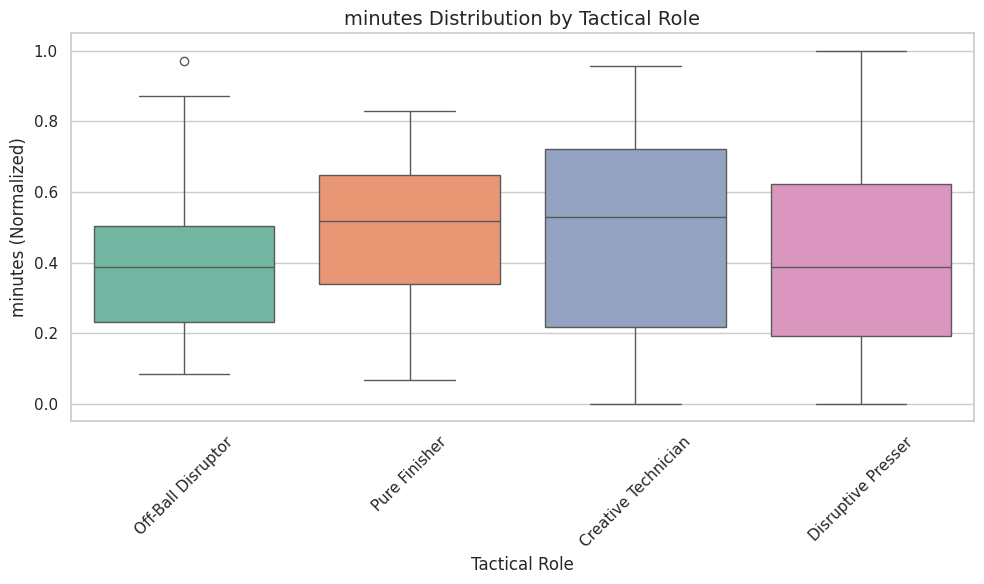

/tmp/ipython-input-23-2746179376.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Role_Label", y=metric, palette="Set2")


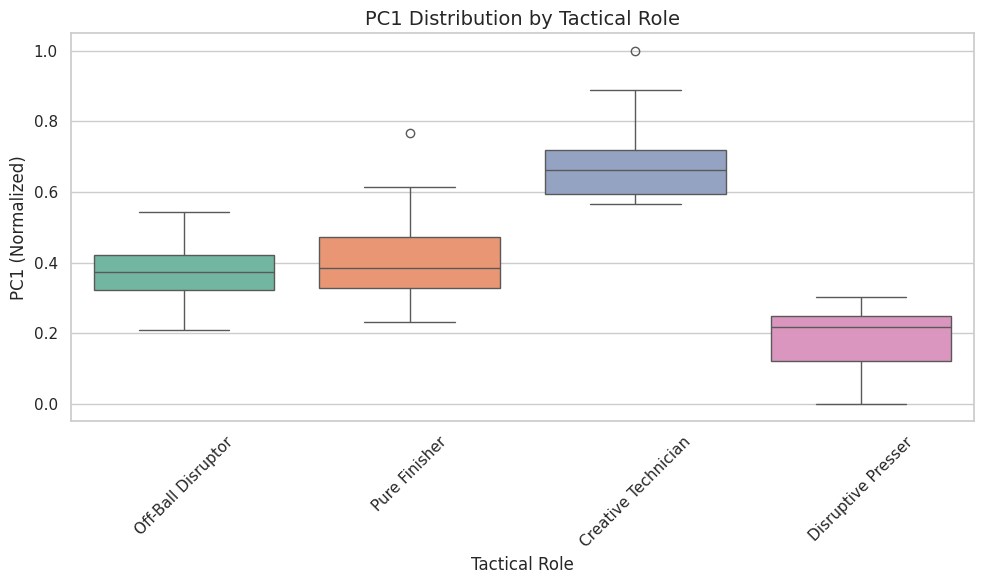

/tmp/ipython-input-23-2746179376.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Role_Label", y=metric, palette="Set2")


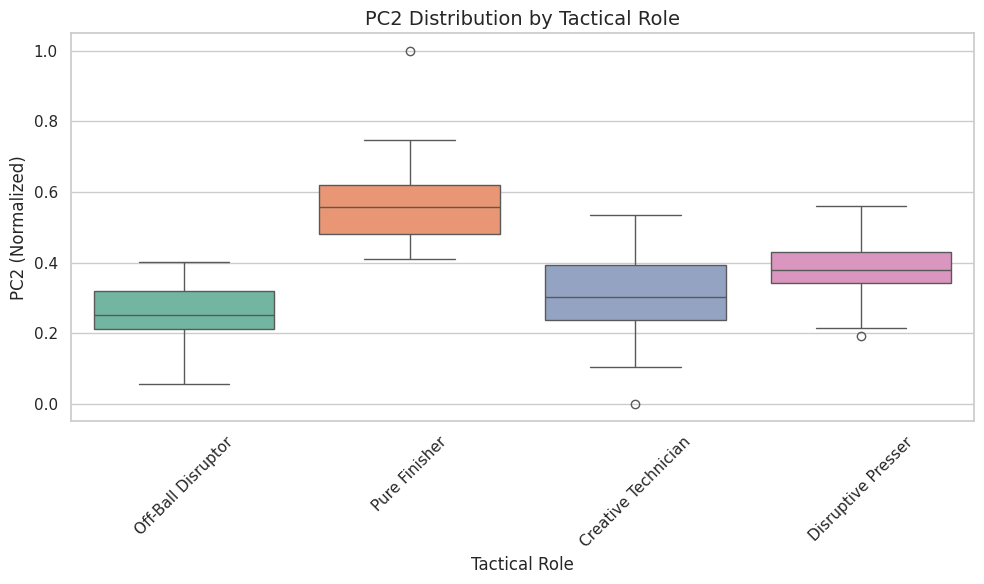

/tmp/ipython-input-23-2746179376.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Role_Label", y=metric, palette="Set2")


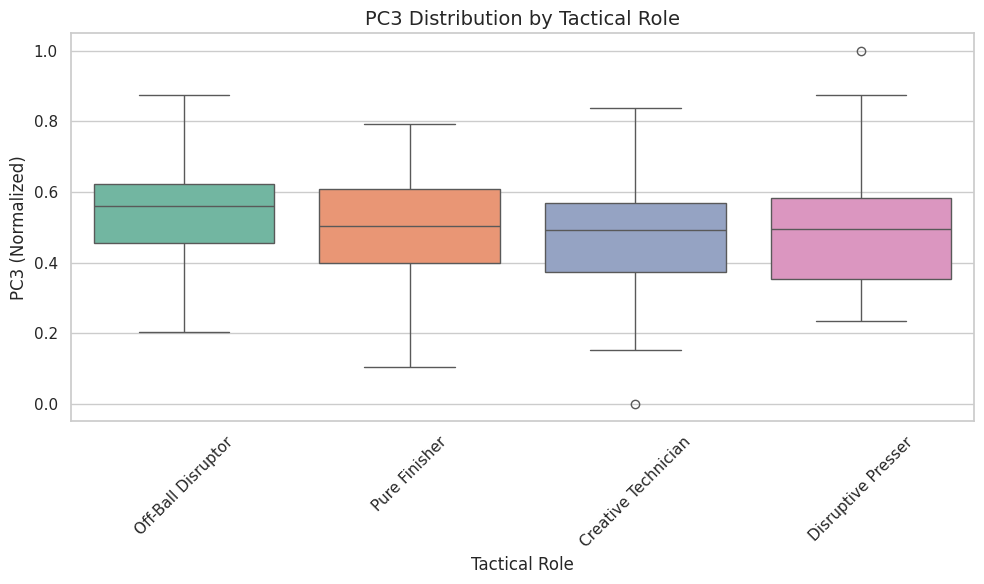

/tmp/ipython-input-23-2746179376.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Role_Label", y=metric, palette="Set2")


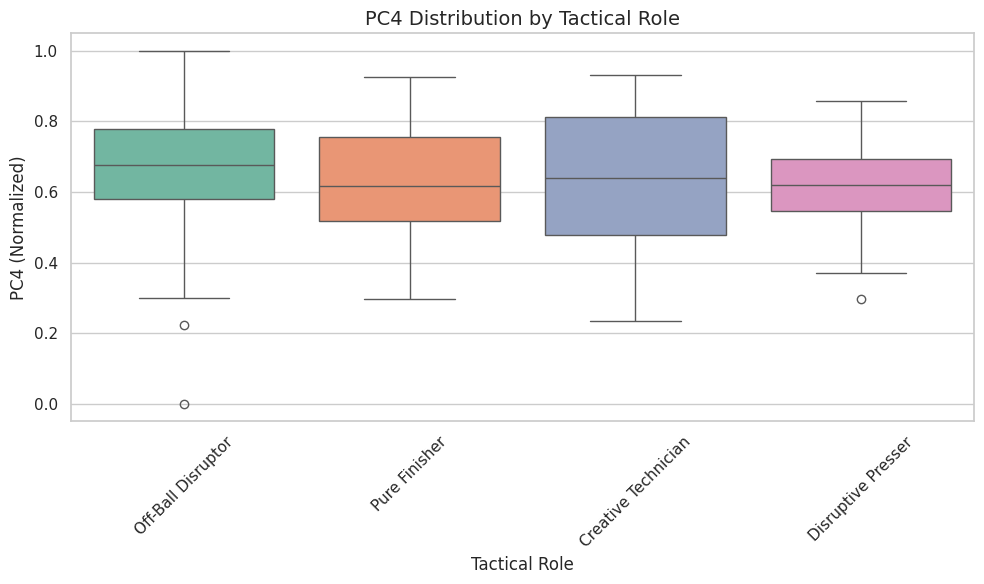

/tmp/ipython-input-23-2746179376.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Role_Label", y=metric, palette="Set2")


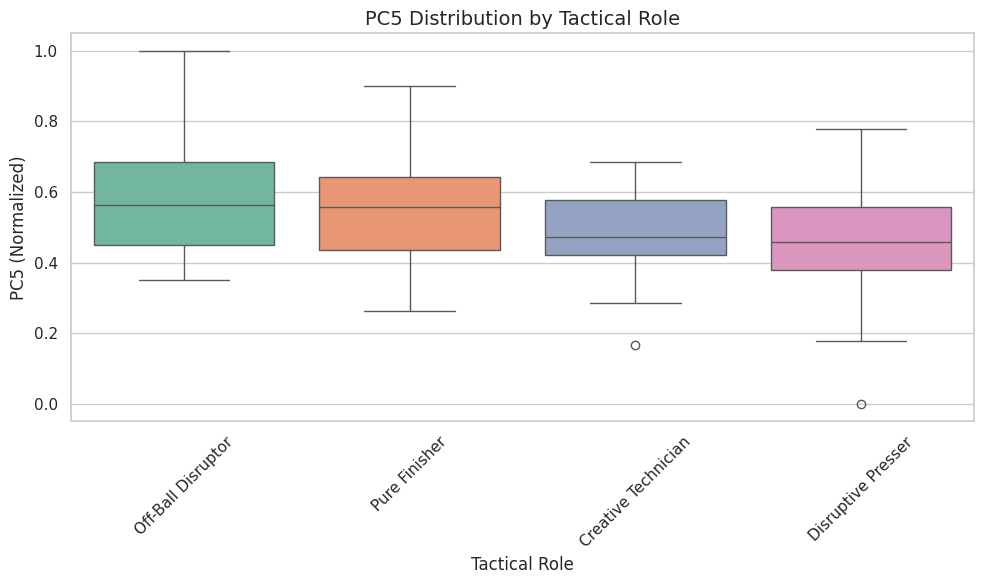

/tmp/ipython-input-23-2746179376.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Role_Label", y=metric, palette="Set2")


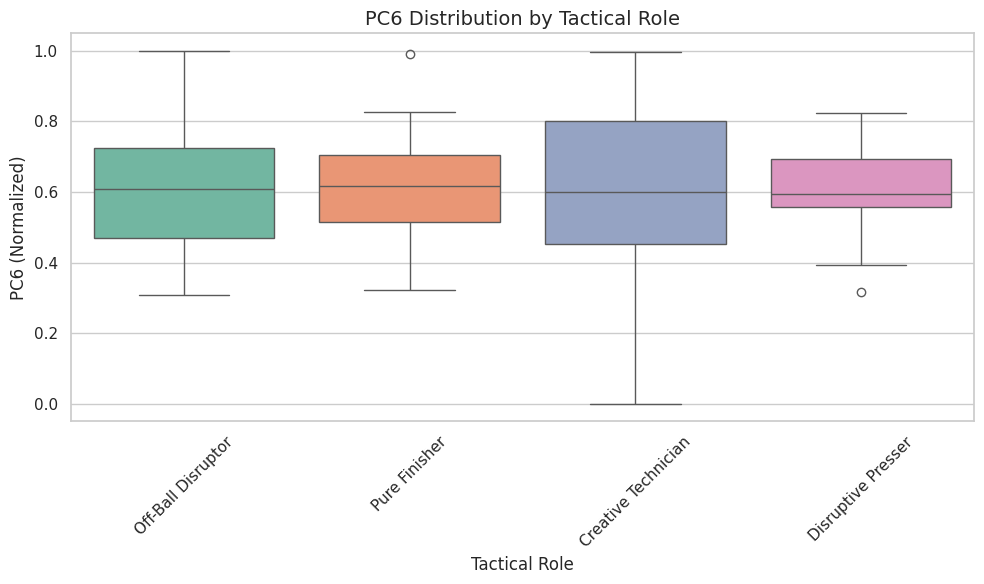

/tmp/ipython-input-23-2746179376.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Role_Label", y=metric, palette="Set2")


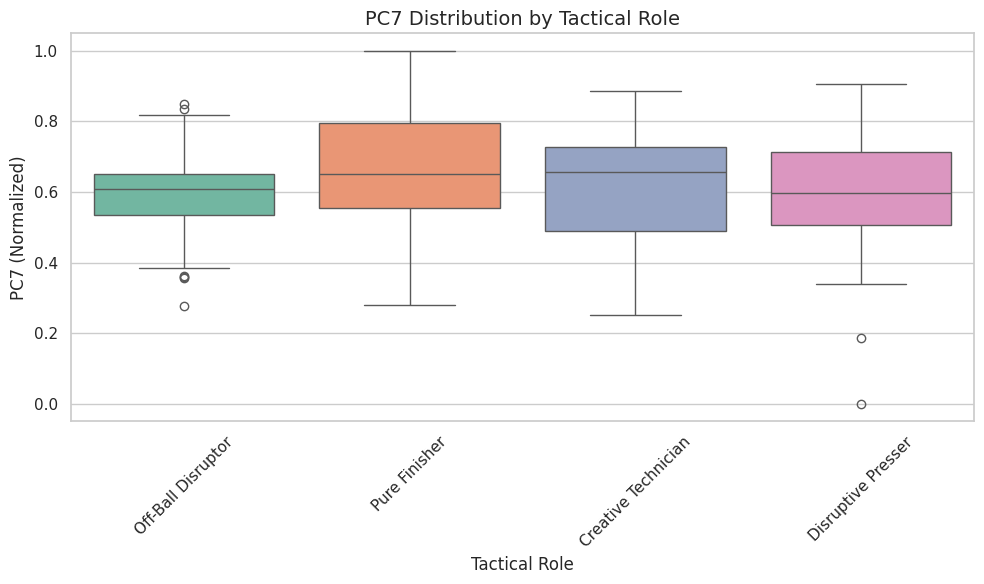

/tmp/ipython-input-23-2746179376.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Role_Label", y=metric, palette="Set2")


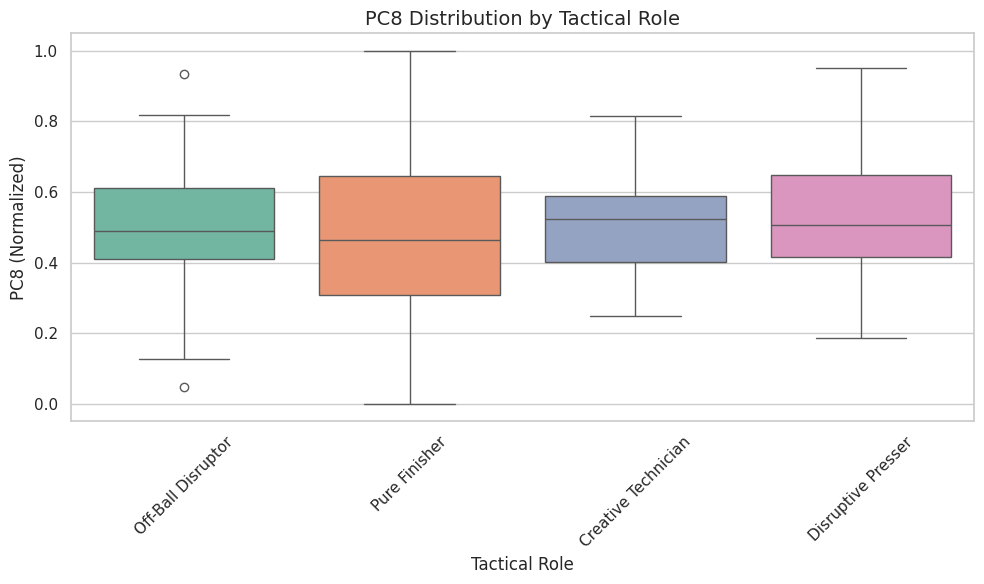

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Load enriched and scaled dataset ---
df = pd.read_csv("global_forwards_2023_24_clustered_roles_scaled_enriched.csv")

# --- Define normalized metrics (from PCA and minutes) ---
scaled_metrics = ["minutes", "PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8"]

# --- Create boxplots by tactical role ---
sns.set(style="whitegrid")

for metric in scaled_metrics:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x="Role_Label", y=metric, palette="Set2")
    plt.title(f"{metric} Distribution by Tactical Role", fontsize=14)
    plt.xlabel("Tactical Role")
    plt.ylabel(f"{metric} (Normalized)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


#Based on the boxplots and the cluster interpretations I've developed:

#Outliers in Goal Scoring (goals_p90) and Shot Volume (shots_total_p90):

These outliers likely belong to the "Pure Finishers" (Cluster 1). They are players who are exceptionally prolific in front of goal and take a much higher volume of shots compared to the average forward across the three leagues. Their boxplots would show data points far above the upper whisker.

#Outliers in Playmaking (assists_p90, passes_key_p90, passes_total_p90):

Outliers here are probably linked to the "Creative Technicians" (Cluster 2). These individuals stand out for their high involvement in build-up play, chance creation, and overall passing volume. Their boxplots would show points significantly above the main distribution for these passing and assist metrics.

#Outliers in Dribbling (dribbles_attempts_p90, dribbles_success_p90, dribbles_success_perc):

 While dribbling metrics show a broader spread, outliers on the high end could indicate players who are either exceptionally high-volume dribblers or highly effective ones. These might be found within the "Creative Technicians" (Cluster 2) who use dribbling as a key part of their creative process, or potentially some players from the "Off-Ball Disruptors" (Cluster 0) who rely on individual actions in wider areas.

#Outliers in Duels (duels_total_p90, duels_won_p90):

High outliers in these metrics are characteristic of the "Disruptive Pressers" (Cluster 3). These players are outliers in terms of their physical engagement, consistently participating in and winning a high number of duels, likely reflecting their role in pressing and disrupting the opposition.

In essence, the outliers highlight players who are exceptional or significantly different in specific tactical aspects, often aligning with the defined clusters. They are the players who push the boundaries of the typical forward profile in Serie A, Ligue 1, and La Liga.

### Flagging Tactical Outliers

I’m applying IQR-based flags to performance metrics in order to systematically identify forwards who stand out significantly from typical role behavior in Serie A, Ligue 1, and La Liga. These flagged outliers serve multiple strategic purposes:

- **To Highlight Exceptional Tactical Traits**  
  Players exceeding expected ranges in shooting, passing, dribbling, or duels often embody extreme forms of their assigned tactical roles — such as pure finishers with ultra-high shot volume or disruptive pressers with relentless duel engagement.

- **To Enhance Scouting Precision**  
  Flagged players represent unique profiles worth deeper scouting analysis. They may push boundaries tactically, offering coaches high-impact or niche functionality in specific systems.

- **To Validate and Challenge Cluster Assignments**  
  Seeing which players deviate sharply within a cluster helps me evaluate whether role labels need refinement, reassignment, or subclassification.

- **To Prepare Visual and Interactive Insights**  
  These flags will be used for filtering in dashboards, overlaying on PCA scatterplots, or generating curated watchlists — making the profiling framework dynamic and interpretable.

This isn’t just anomaly detection , it’s about surfacing high-signal tactical outliers who may define new archetypes or challenge existing role boundaries. It’s where data meets football nuance.


In [ ]:
import pandas as pd

# --- Load scaled + enriched tactical dataset ---
df_enriched = pd.read_csv("global_forwards_2023_24_clustered_roles_scaled_enriched.csv")

# --- Load scaled metrics dataset used for PCA inputs and outlier detection ---
df_scaled_metrics = pd.read_csv("global_forwards_2023_24_scaled_metrics_final.csv")

# --- Ensure merge keys are string-type and standardized ---
for df in [df_enriched, df_scaled_metrics]:
    for col in ["name", "team_clean", "league", "position", "minutes"]:
        df[col] = df[col].astype(str).str.strip().str.lower()

# --- Merge on identity columns with strict match requirements ---
df = pd.merge(
    df_enriched,
    df_scaled_metrics,
    on=["name", "team_clean", "league", "position", "minutes"],
    how="inner"
)

print("✅ Merged enriched dataset with scaled metrics for outlier detection.")
print(f"Merged dataset shape: {df.shape}")

# --- Define tactical metrics for IQR-based outlier detection ---
outlier_metrics = {
    "Goal_Scoring": ["goals_p90", "shots_total_p90"],
    "Playmaking": ["assists_p90", "passes_key_p90", "passes_total_p90"],
    "Dribbling": ["dribbles_success_perc"],
    "Duels": ["duels_win_perc"]
}

# --- Apply IQR outlier flags per trait group ---
for group, metrics in outlier_metrics.items():
    for metric in metrics:
        if metric in df.columns:
            Q1 = df[metric].quantile(0.25)
            Q3 = df[metric].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            flag_name = f"outlier_{metric}"
            df[flag_name] = (df[metric] < lower_bound) | (df[metric] > upper_bound)
            print(f"Applied outlier flag for: {metric}")
        else:
            print(f"⚠️ Metric '{metric}' not found — skipping outlier detection.")

# --- Create summary tactical flags by trait ---
summary_flag_groups = {
    "goal_scoring": ["outlier_goals_p90", "outlier_shots_total_p90"],
    "playmaking": ["outlier_assists_p90", "outlier_passes_key_p90", "outlier_passes_total_p90"],
    "dribbling": ["outlier_dribbles_success_perc"],
    "duels": ["outlier_duels_win_perc"]
}

for summary_flag, component_flags in summary_flag_groups.items():
    available_flags = [f for f in component_flags if f in df.columns]
    if available_flags:
        df[f"outlier_{summary_flag}"] = df[available_flags].any(axis=1)
        print(f"✅ Created summary flag: outlier_{summary_flag}")
    else:
        print(f"⚠️ Missing components for summary flag: outlier_{summary_flag}")

# --- Save enriched and flagged dataset ---
df.to_csv("global_forwards_2023_24_clustered_roles_outlier_flags.csv", index=False)
print("\n✅ Tactical outlier flags saved to 'global_forwards_2023_24_clustered_roles_outlier_flags.csv'")


✅ Merged enriched dataset with scaled metrics for outlier detection.
Merged dataset shape: (0, 23)
Applied outlier flag for: goals_p90
Applied outlier flag for: shots_total_p90
Applied outlier flag for: assists_p90
Applied outlier flag for: passes_key_p90
Applied outlier flag for: passes_total_p90
Applied outlier flag for: dribbles_success_perc
Applied outlier flag for: duels_win_perc
✅ Created summary flag: outlier_goal_scoring
✅ Created summary flag: outlier_playmaking
✅ Created summary flag: outlier_dribbling
✅ Created summary flag: outlier_duels

✅ Tactical outlier flags saved to 'global_forwards_2023_24_clustered_roles_outlier_flags.csv'


In [ ]:
import pandas as pd

# Load the outliers file
df_outliers = pd.read_csv("global_forwards_2023_24_clustered_roles_outlier_flags.csv")

# Basic overview
print("📐 Shape:", df_outliers.shape)
print("🧬 Columns:", df_outliers.columns.tolist())
display(df_outliers.head())

# Check for missing values
missing_counts = df_outliers.isnull().sum()
missing_percent = (missing_counts / len(df_outliers)) * 100

missing_summary = pd.DataFrame({
    "Missing Count": missing_counts,
    "Missing %": missing_percent.round(1)
}).sort_values(by="Missing Count", ascending=False)

print("\n🧼 Missing Values Summary:")
display(missing_summary)

# Flag distribution across metrics
flag_columns = [col for col in df_outliers.columns if "_outlier_flag" in col]
print("\n🚨 Outlier Flag Distribution:")
for col in flag_columns:
    print(f"{col}: {df_outliers[col].sum()} flagged")

# Optional: preview flagged rows
flagged_rows = df_outliers[df_outliers[flag_columns].sum(axis=1) > 0]
print("\n🎯 Sample Flagged Profiles:")
display(flagged_rows.head())


📐 Shape: (0, 34)
🧬 Columns: ['name', 'team_clean', 'league', 'position', 'Cluster', 'Role_Label', 'minutes', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'goals_p90', 'shots_total_p90', 'assists_p90', 'passes_key_p90', 'passes_total_p90', 'passes_accuracy_perc', 'dribbles_success_perc', 'duels_win_perc', 'outlier_goals_p90', 'outlier_shots_total_p90', 'outlier_assists_p90', 'outlier_passes_key_p90', 'outlier_passes_total_p90', 'outlier_dribbles_success_perc', 'outlier_duels_win_perc', 'outlier_goal_scoring', 'outlier_playmaking', 'outlier_dribbling', 'outlier_duels']


,name,team_clean,league,position,Cluster,Role_Label,minutes,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,goals_p90,shots_total_p90,assists_p90,passes_key_p90,passes_total_p90,passes_accuracy_perc,dribbles_success_perc,duels_win_perc,outlier_goals_p90,outlier_shots_total_p90,outlier_assists_p90,outlier_passes_key_p90,outlier_passes_total_p90,outlier_dribbles_success_perc,outlier_duels_win_perc,outlier_goal_scoring,outlier_playmaking,outlier_dribbling,outlier_duels



🧼 Missing Values Summary:


,Missing Count,Missing %
name,0,NaN
team_clean,0,NaN
league,0,NaN
position,0,NaN
Cluster,0,NaN
Role_Label,0,NaN
minutes,0,NaN
PC1,0,NaN
PC2,0,NaN
PC3,0,NaN



🚨 Outlier Flag Distribution:

🎯 Sample Flagged Profiles:


,name,team_clean,league,position,Cluster,Role_Label,minutes,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,goals_p90,shots_total_p90,assists_p90,passes_key_p90,passes_total_p90,passes_accuracy_perc,dribbles_success_perc,duels_win_perc,outlier_goals_p90,outlier_shots_total_p90,outlier_assists_p90,outlier_passes_key_p90,outlier_passes_total_p90,outlier_dribbles_success_perc,outlier_duels_win_perc,outlier_goal_scoring,outlier_playmaking,outlier_dribbling,outlier_duels


In [ ]:
import pandas as pd


df.head()  # Show top rows
df.info()  # Overview of non-null counts and datatypes
df.describe()  # Stats summary for numeric columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   name                           0 non-null      object 
 1   team_clean                     0 non-null      object 
 2   league                         0 non-null      object 
 3   position                       0 non-null      object 
 4   Cluster                        0 non-null      int64  
 5   Role_Label                     0 non-null      object 
 6   minutes                        0 non-null      object 
 7   PC1                            0 non-null      float64
 8   PC2                            0 non-null      float64
 9   PC3                            0 non-null      float64
 10  PC4                            0 non-null      float64
 11  PC5                            0 non-null      float64
 12  PC6                            0 non-null      float64
 13  PC

,Cluster,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,goals_p90,shots_total_p90,assists_p90,passes_key_p90,passes_total_p90,passes_accuracy_perc,dribbles_success_perc,duels_win_perc
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


I am creating a final dataframe to include all the metrics for my players.

In [ ]:
import pandas as pd

# --- Load enriched role-labeled dataset ---
df_roles = pd.read_csv("global_forwards_2023_24_clustered_roles_scaled_enriched.csv")

# --- Load outlier flag + metrics dataset ---
df_metrics = pd.read_csv("global_forwards_2023_24_clustered_roles_outlier_flags.csv")

# --- Standardize merge keys to avoid mismatches ---
for df in [df_roles, df_metrics]:
    for col in ["name", "team_clean", "league"]:
        df[col] = df[col].astype(str).str.strip().str.lower()

# --- Merge datasets on identity keys ---
df_combined = pd.merge(df_roles, df_metrics, on=["name", "team_clean", "league"], how="left")

# --- Preview merged shape and column count ---
print("✅ Final merged dataset created.")
print(f"Combined shape: {df_combined.shape}")
print(f"Column count: {len(df_combined.columns)}")

# --- Save master output for app ingestion or audit trails ---
df_combined.to_csv("global_forwards_2023_24_merged_all.csv", index=False)
print("📦 Saved final dataset as 'global_forwards_2023_24_merged_all.csv'")


✅ Final merged dataset created.
Combined shape: (130, 46)
Column count: 46
📦 Saved final dataset as 'global_forwards_2023_24_merged_all.csv'


In [ ]:
import pandas as pd

df = pd.read_csv("global_forwards_2023_24_merged_all.csv")
print("Shape:", df.shape)
df.head()


Shape: (130, 46)


,name,team_clean,league,position_x,Cluster_x,Role_Label_x,minutes_x,PC1_x,PC2_x,PC3_x,PC4_x,PC5_x,PC6_x,PC7_x,PC8_x,position_y,Cluster_y,Role_Label_y,minutes_y,PC1_y,PC2_y,PC3_y,PC4_y,PC5_y,PC6_y,PC7_y,PC8_y,goals_p90,shots_total_p90,assists_p90,passes_key_p90,passes_total_p90,passes_accuracy_perc,dribbles_success_perc,duels_win_perc,outlier_goals_p90,outlier_shots_total_p90,outlier_assists_p90,outlier_passes_key_p90,outlier_passes_total_p90,outlier_dribbles_success_perc,outlier_duels_win_perc,outlier_goal_scoring,outlier_playmaking,outlier_dribbling,outlier_duels
0,f. caputo,empoli,serie a,attacker,0,Off-Ball Disruptor,0.282797,0.207773,0.255681,0.456926,0.900751,0.743144,0.594964,0.630786,0.296324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,i. success,udinese,serie a,attacker,0,Off-Ball Disruptor,0.124116,0.334786,0.218556,0.201705,0.651608,0.562257,0.478349,0.523940,0.653187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,dany mota,monza,serie a,attacker,0,Off-Ball Disruptor,0.590338,0.418839,0.229965,0.752691,0.581072,0.408336,0.611211,0.651934,0.567061,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,a. petagna,cagliari,serie a,attacker,0,Off-Ball Disruptor,0.174784,0.461741,0.121789,0.223904,0.795778,0.799492,0.377499,0.608647,0.364336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,g. oristanio,cagliari,serie a,attacker,0,Off-Ball Disruptor,0.214847,0.286152,0.240308,0.326725,0.656898,0.716880,0.473852,0.543890,0.416882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
missing_counts = df.isnull().sum()
missing_percent = (missing_counts / len(df)) * 100

missing_summary = pd.DataFrame({
    "Missing Count": missing_counts,
    "Missing %": missing_percent.round(1)
}).sort_values(by="Missing Count", ascending=False)

missing_summary


,Missing Count,Missing %
goals_p90,130,100.0
shots_total_p90,130,100.0
PC7_y,130,100.0
PC6_y,130,100.0
PC5_y,130,100.0
PC8_y,130,100.0
PC4_y,130,100.0
PC3_y,130,100.0
PC1_y,130,100.0
PC2_y,130,100.0


In [ ]:
import pandas as pd

# Load datasets
df_metrics = pd.read_csv("global_forwards_2023_24_scaled_metrics_final.csv")
df_roles = pd.read_csv("global_forwards_2023_24_clustered_roles.csv")

# Only keep necessary columns from the roles file
df_roles_trimmed = df_roles[["name", "Cluster", "Role_Label"]]

# Merge on 'name'
merged_df = pd.merge(df_metrics, df_roles_trimmed, on="name", how="left")

# Post-merge checks
print("✅ Merged dataset shape:", merged_df.shape)
missing_roles = merged_df["Role_Label"].isnull().sum()
print("🧠 Players missing Role_Label:", missing_roles)

# Optional: investigate missing matches if needed
if missing_roles > 0:
    display(merged_df[merged_df["Role_Label"].isnull()])


✅ Merged dataset shape: (130, 15)
🧠 Players missing Role_Label: 0


Merging the 2 datasets needed for my application and inspecting them.

In [ ]:
import pandas as pd

# 🟢 Step 1: Load datasets
df_metrics = pd.read_csv("global_forwards_2023_24_scaled_metrics_final.csv")
df_roles = pd.read_csv("global_forwards_2023_24_clustered_roles.csv")

# 🧬 Step 2: Merge on shared keys
df_merged = pd.merge(
    df_metrics,
    df_roles,
    on=['name', 'team_clean'],
    how='inner'
)

# 🔍 Step 3: Inspect merged structure
print("\n🎯 Dataset Overview")
print("Shape:", df_merged.shape)
print("\nColumn Names:", df_merged.columns.tolist())

# 🔎 Step 4: Check for missing values
print("\n🔎 Missing Values Summary")
missing_summary = df_merged.isnull().sum()
missing_summary = missing_summary[missing_summary > 0]
print(missing_summary if not missing_summary.empty else "No missing values detected")

# 📊 Step 5: Structural overview
print("\n📊 Data Types & Non-Null Counts")
print(df_merged.info())

print("\n📈 Statistical Summary")
print(df_merged.describe(include='all'))

print("\n🧠 Unique Players vs Rows")
print("Unique names:", df_merged['name'].nunique())
print("Total rows:", df_merged.shape[0])

# 🧹 Step 6: Drop duplicate columns & rename
df_merged.drop(columns=['league_y', 'position_y', 'minutes_y'], inplace=True)
df_merged.rename(columns={
    'league_x': 'league',
    'position_x': 'position',
    'minutes_x': 'minutes'
}, inplace=True)

# 🧠 Step 7: Logical column ordering (adaptive)
desired_order = (
    ['name', 'team_clean', 'league', 'position', 'minutes'] +
    [col for col in df_merged.columns if col.startswith('PC')] +
    [col for col in df_merged.columns if '_p90' in col or '_perc' in col] +
    [col for col in df_merged.columns if col.startswith('outlier')] +
    ['Cluster', 'Role_Label']
)
final_order = [col for col in desired_order if col in df_merged.columns]
df_merged = df_merged[final_order]

# 📁 Step 8: Export clean CSV
output_path = "global_forwards_2023_24_merged_app_ready.csv"
df_merged.to_csv(output_path, index=False)
print(f"\n✅ Export complete → {output_path}")



🎯 Dataset Overview
Shape: (130, 26)

Column Names: ['name', 'team_clean', 'league_x', 'position_x', 'minutes_x', 'goals_p90', 'shots_total_p90', 'assists_p90', 'passes_key_p90', 'passes_total_p90', 'passes_accuracy_perc', 'dribbles_success_perc', 'duels_win_perc', 'league_y', 'position_y', 'minutes_y', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'Cluster', 'Role_Label']

🔎 Missing Values Summary
No missing values detected

📊 Data Types & Non-Null Counts
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   130 non-null    object 
 1   team_clean             130 non-null    object 
 2   league_x               130 non-null    object 
 3   position_x             130 non-null    object 
 4   minutes_x              130 non-null    float64
 5   goals_p90              130 non-null    float64
 6   sho

In [ ]:
# Check data types
print("\n🧪 Column Types:")
print(df_merged.dtypes)

# Check suspicious columns for non-numeric values
problem_cols = ['goals_p90', 'shots_total_p90', 'PC1', 'Cluster']
for col in problem_cols:
    print(f"\n🔎 Unique entries in '{col}':")
    print(df_merged[col].unique()[:10])  # Show top 10 unique values

# Optional: Force conversion if needed
for col in df_merged.columns:
    if df_merged[col].dtype == 'object':
        try:
            df_merged[col] = pd.to_numeric(df_merged[col], errors='coerce')
        except:
            pass



🧪 Column Types:
name                      object
team_clean                object
league                    object
position                  object
minutes                  float64
PC1                      float64
PC2                      float64
PC3                      float64
PC4                      float64
PC5                      float64
PC6                      float64
PC7                      float64
PC8                      float64
goals_p90                float64
shots_total_p90          float64
assists_p90              float64
passes_key_p90           float64
passes_total_p90         float64
passes_accuracy_perc     float64
dribbles_success_perc    float64
duels_win_perc           float64
Cluster                    int64
Role_Label                object
dtype: object

🔎 Unique entries in 'goals_p90':
[-0.56717461 -1.12507375  0.78753467 -0.75703862 -1.19377156 -0.81630581
 -0.01472029 -0.77420684  0.19296212  1.26739632]

🔎 Unique entries in 'shots_total_p90':
[-0.94041354 

### 10.  PCA Component Interpretation Step

This section analyzes the correlation between each principal component (e.g., PC1, PC2) and the original encoded features in the dataset. The goal is to identify which metrics most strongly contribute to each component, allowing us to assign tactical meanings (e.g., "Goal Threat", "Playmaking Activity") to otherwise abstract PCA axes. This step transforms technical dimensionality reduction into interpretable footballing themes, essential for labeling player clusters and enhancing scouting insights.


First I am merging the 2 datasets needed.

In [ ]:
import pandas as pd

# 🔹 Load encoded metrics
encoded_df = pd.read_csv("global_forwards_2023_24_encoded.csv")

# 🔹 Load PCA-transformed components
pca_df = pd.read_csv("global_forwards_2023_24_pca_transformed.csv")

# 🧩 Align dataframes: Make sure both have same row order & matching index
# If both files align row-by-row (e.g. sorted by player name beforehand), you're good to go

# ✅ Reset index just in case and merge
merged_df = pd.concat([encoded_df.reset_index(drop=True), pca_df.reset_index(drop=True)], axis=1)

# 💾 Save merged dataset
merged_df.to_csv("global_forwards_2023_24_encoded_with_pca.csv", index=False)
print("✅ Merge complete — saved to global_forwards_2023_24_encoded_with_pca.csv")


✅ Merge complete — saved to global_forwards_2023_24_encoded_with_pca.csv


I am inspecting for missing values and for which columns are included on my new dataframe.

In [ ]:
import pandas as pd

# 🔹 Load merged dataset
merged_df = pd.read_csv("global_forwards_2023_24_encoded_with_pca.csv")

# 🧾 View all column names
print("🔍 Column overview:")
print(merged_df.columns.tolist())

# 🧼 Check for missing values
missing_summary = merged_df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0]

print("\n🧼 Missing values detected:")
print(missing_summary)


🔍 Column overview:
['name', 'position', 'minutes', 'duels_total_api', 'duels_won_api', 'goals_total_api', 'shots_total_api', 'shots_on_target_api', 'assists_total_api', 'dribbles_attempts_api', 'dribbles_success_api', 'touches_total_api', 'passes_key_api', 'passes_total_api', 'passes_accuracy_perc', 'shots_on_target_perc', 'dribbles_success_perc', 'name_clean', 'team_clean', 'duels_total_p90', 'duels_won_p90', 'goals_p90', 'shots_total_p90', 'shots_on_target_p90', 'assists_p90', 'dribbles_attempts_p90', 'dribbles_success_p90', 'touches_total_p90', 'passes_key_p90', 'passes_total_p90', 'team_AS Roma', 'team_Atalanta', 'team_Bologna', 'team_Cagliari', 'team_Empoli', 'team_Fiorentina', 'team_Genoa', 'team_Inter', 'team_Juventus', 'team_Lazio', 'team_Lecce', 'team_Monza', 'team_Napoli', 'team_Salernitana', 'team_Sassuolo', 'team_Torino', 'team_Udinese', 'team_Verona', 'league', 'team_Le Havre', 'team_Lens', 'team_Lille', 'team_Lorient', 'team_Lyon', 'team_Marseille', 'team_Metz', 'team_Mon

I need to drop some columns as they were missing when I inspected the dataframe at the beggining.

In [ ]:
import pandas as pd

# 🔹 Load merged dataset
merged_df = pd.read_csv("global_forwards_2023_24_encoded_with_pca.csv")

# 🚫 Drop features with zero variance
cols_to_drop = [
    "shots_on_target_p90",
    "shots_on_target_perc",
    "touches_total_p90"
]
cleaned_df = merged_df.drop(columns=cols_to_drop)

# 🧼 Fill missing values in one-hot encoded team columns with 0
team_cols = [col for col in cleaned_df.columns if col.startswith("team_")]
cleaned_df[team_cols] = cleaned_df[team_cols].fillna(0)

# 📋 View updated column list
print("📋 Updated columns:")
print(cleaned_df.columns.tolist())

# 🧮 Check for any remaining missing values
missing_summary = cleaned_df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0]
print("\n🧼 Columns with missing values:")
print(missing_summary)


📋 Updated columns:
['name', 'position', 'minutes', 'duels_total_api', 'duels_won_api', 'goals_total_api', 'shots_total_api', 'shots_on_target_api', 'assists_total_api', 'dribbles_attempts_api', 'dribbles_success_api', 'touches_total_api', 'passes_key_api', 'passes_total_api', 'passes_accuracy_perc', 'dribbles_success_perc', 'name_clean', 'team_clean', 'duels_total_p90', 'duels_won_p90', 'goals_p90', 'shots_total_p90', 'assists_p90', 'dribbles_attempts_p90', 'dribbles_success_p90', 'passes_key_p90', 'passes_total_p90', 'team_AS Roma', 'team_Atalanta', 'team_Bologna', 'team_Cagliari', 'team_Empoli', 'team_Fiorentina', 'team_Genoa', 'team_Inter', 'team_Juventus', 'team_Lazio', 'team_Lecce', 'team_Monza', 'team_Napoli', 'team_Salernitana', 'team_Sassuolo', 'team_Torino', 'team_Udinese', 'team_Verona', 'league', 'team_Le Havre', 'team_Lens', 'team_Lille', 'team_Lorient', 'team_Lyon', 'team_Marseille', 'team_Metz', 'team_Monaco', 'team_Montpellier', 'team_Nantes', 'team_Nice', 'team_Paris Sa

In [ ]:
# ✅ Using the cleaned dataframe with PCA + metrics
import pandas as pd

cleaned_df = pd.read_csv("global_forwards_2023_24_encoded_with_pca.csv")

# 🔹 Drop previously flagged features for consistency
cols_to_drop = ["shots_on_target_p90", "shots_on_target_perc", "touches_total_p90"]
cleaned_df = cleaned_df.drop(columns=cols_to_drop)

# 🔹 Fill NaNs in one-hot encoded team columns
team_cols = [col for col in cleaned_df.columns if col.startswith("team_")]
cleaned_df[team_cols] = cleaned_df[team_cols].fillna(0)

# 🔹 Select only numeric columns
numeric_df = cleaned_df.select_dtypes(include="number")

# 🧠 Correlate each principal component with original metrics
for i in range(1, 9):
    axis = f"PC{i}"
    correlations = numeric_df.corr()[axis].sort_values(ascending=False)
    print(f"\n📈 Top features driving {axis}:")
    print(correlations.head(10))



📈 Top features driving PC1:
PC1                      1.000000
passes_total_p90         0.818087
passes_key_p90           0.807473
assists_p90              0.712652
assists_total_api        0.676311
passes_key_api           0.655730
passes_total_api         0.596363
dribbles_success_p90     0.537449
dribbles_success_api     0.521531
dribbles_success_perc    0.519846
Name: PC1, dtype: float64

📈 Top features driving PC2:
PC2                     1.000000
goals_p90               0.895756
shots_total_p90         0.864003
goals_total_api         0.740833
shots_total_api         0.635741
minutes                 0.108659
minutes.1               0.108659
assists_total_api       0.100244
passes_accuracy_perc    0.085007
assists_p90             0.076103
Name: PC2, dtype: float64

📈 Top features driving PC3:
PC3                      1.000000e+00
passes_accuracy_perc     5.500693e-01
passes_total_p90         3.729850e-01
dribbles_attempts_p90    1.670641e-01
passes_total_api         1.408428e-01
p

###  PCA Component Interpretation — Tactical Labeling Summary

Each principal component has been interpreted based on its correlation with key football metrics. These components are now renamed using tactical role labels to enhance readability and strategic relevance in your app and scouting reports.

For example:

- PC1 emphasizes creative playmaking, driven by metrics like passes, key passes, and assists.
- PC2 reflects goal-scoring instinct and shot volume.
- PC3 captures technical passing and dribbling qualities.
- PC4 identifies efficiency in ball control and execution.
- PC5 combines retention and final-third impact.
- PC6 highlights support under pressure via assists and duels.
- PC7 represents broader match involvement and role identity.

Regarding PC8: it shows low-weight, mixed signals across metrics and may represent residual noise rather than meaningful traits. It’s safer to exclude such components if they don’t improve interpretability or contribute significantly to variance explained.



Now I will also need to use raw metrics from my individual league notebooks in order to include them on my app and see the actual numbers and percentages for the forwards, as the global_forwards_2023_24_merged_app_ready.csv includes scaled metrics.

In [ ]:
import pandas as pd

#  Load preprocessed forward datasets
seriea_df = pd.read_csv("seriea_forwards_2023_24_preprocessed.csv")
ligue1_df = pd.read_csv("ligue1_forwards_2023_24_preprocessed.csv")
laliga_df = pd.read_csv("laliga_forwards_2023_24_preprocessed.csv")

#  Add league labels for context
seriea_df["league"] = "Serie A"
ligue1_df["league"] = "Ligue 1"
laliga_df["league"] = "La Liga"

#  Merge vertically
merged_raw_df = pd.concat([seriea_df, ligue1_df, laliga_df], ignore_index=True)

#  Export unified raw metrics with player names intact
output_path = "merged_global_forwards_raw_metrics_with_names.csv"
merged_raw_df.to_csv(output_path, index=False)

print(f"✅ Raw metrics export complete → {output_path}")


✅ Raw metrics export complete → merged_global_forwards_raw_metrics_with_names.csv


Comparing Column Structures of the Three League Datasets



In [ ]:
#  Convert column lists to sets for easy comparison
seriea_cols = set(seriea_df.columns)
ligue1_cols = set(ligue1_df.columns)
laliga_cols = set(laliga_df.columns)

#  Find common columns
common_cols = seriea_cols & ligue1_cols & laliga_cols
print(f"✅ Columns common to all three leagues ({len(common_cols)}):\n", sorted(common_cols))

#  Find unique columns in each league
print("\n🇮🇹 Columns only in Serie A:")
print(sorted(seriea_cols - ligue1_cols - laliga_cols))

print("\n🇫🇷 Columns only in Ligue 1:")
print(sorted(ligue1_cols - seriea_cols - laliga_cols))

print("\n🇪🇸 Columns only in La Liga:")
print(sorted(laliga_cols - seriea_cols - ligue1_cols))


✅ Columns common to all three leagues (32):
 ['assists_p90', 'assists_total_api', 'dribbles_attempts_api', 'dribbles_attempts_p90', 'dribbles_success_api', 'dribbles_success_p90', 'dribbles_success_perc', 'duels_total_api', 'duels_total_p90', 'duels_won_api', 'duels_won_p90', 'goals_p90', 'goals_total_api', 'league', 'minutes', 'name', 'name_clean', 'passes_accuracy_perc', 'passes_key_api', 'passes_key_p90', 'passes_total_api', 'passes_total_p90', 'position', 'shots_on_target_api', 'shots_on_target_p90', 'shots_on_target_perc', 'shots_total_api', 'shots_total_p90', 'team', 'team_clean', 'touches_total_api', 'touches_total_p90']

🇮🇹 Columns only in Serie A:
[]

🇫🇷 Columns only in Ligue 1:
[]

🇪🇸 Columns only in La Liga:
[]


Merging the 3 leagues , adding the league column and inspecting for missing values.

In [ ]:
import pandas as pd

#  Load and tag each DataFrame with its league
seriea_df = pd.read_csv("seriea_forwards_2023_24_preprocessed.csv")
ligue1_df = pd.read_csv("ligue1_forwards_2023_24_preprocessed.csv")
laliga_df = pd.read_csv("laliga_forwards_2023_24_preprocessed.csv")

seriea_df["league"] = "Serie A"
ligue1_df["league"] = "Ligue 1"
laliga_df["league"] = "La Liga"

#  Merge them into one unified DataFrame
merged_df = pd.concat([seriea_df, ligue1_df, laliga_df], ignore_index=True)
print(f"Merged shape: {merged_df.shape}")
print(merged_df.head())

#  Inspect for missing values
missing_summary = merged_df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0]

print(f"\n Columns with missing values ({len(missing_summary)}):")
print(missing_summary.sort_values(ascending=False))


Merged shape: (130, 33)
         name      team  position  minutes  duels_total_api  duels_won_api  \
0   F. Caputo    Empoli  Attacker   1274.0             80.0           33.0   
1  I. Success   Udinese  Attacker    870.0            186.0           87.0   
2   S. Azmoun   AS Roma  Attacker    568.0             80.0           36.0   
3   Dany Mota     Monza  Attacker   2057.0            233.0           97.0   
4  A. Petagna  Cagliari  Attacker    999.0            135.0           63.0   

   goals_total_api  shots_total_api  shots_on_target_api  assists_total_api  \
0              3.0             18.0                    0                0.0   
1              1.0             16.0                    0                1.0   
2              3.0             11.0                    0                0.0   
3              4.0             29.0                    0                3.0   
4              1.0             13.0                    0                1.0   

   ...  goals_p90  shots_total_p

Dropping columns with missing values.

In [ ]:
import pandas as pd

#  Load the original dataset
raw_metrics_df = pd.read_csv("merged_global_forwards_raw_metrics_with_names.csv")

#  Columns to drop
drop_cols = ["shots_on_target_api", "shots_on_target_p90", "touches_total_p90"]
raw_metrics_df.drop(columns=drop_cols, inplace=True)

#  Save the cleaned version to a new CSV
raw_metrics_df.to_csv("merged_global_forwards_raw_metrics_cleaned.csv", index=False)

#  Inspect cleaned DataFrame
print(f"Cleaned shape: {raw_metrics_df.shape}")
print("Sample rows:")
print(raw_metrics_df.head())

print("\nColumns after cleanup:")
print(raw_metrics_df.columns.tolist())


Cleaned shape: (130, 30)
Sample rows:
         name      team  position  minutes  duels_total_api  duels_won_api  \
0   F. Caputo    Empoli  Attacker   1274.0             80.0           33.0   
1  I. Success   Udinese  Attacker    870.0            186.0           87.0   
2   S. Azmoun   AS Roma  Attacker    568.0             80.0           36.0   
3   Dany Mota     Monza  Attacker   2057.0            233.0           97.0   
4  A. Petagna  Cagliari  Attacker    999.0            135.0           63.0   

   goals_total_api  shots_total_api  assists_total_api  dribbles_attempts_api  \
0              3.0             18.0                0.0                    9.0   
1              1.0             16.0                1.0                   34.0   
2              3.0             11.0                0.0                   11.0   
3              4.0             29.0                3.0                   44.0   
4              1.0             13.0                1.0                   15.0   

   ...

Checking the present columns in 2 datasets that I want to merge and use on my app.

In [ ]:
import pandas as pd

#  Load both datasets
pca_df = pd.read_csv("global_forwards_2023_24_merged_app_ready.csv")
raw_metrics_df = pd.read_csv("merged_global_forwards_raw_metrics_cleaned.csv")

#  Display columns in each DataFrame
print("\n Columns in raw_metrics_df:")
print(raw_metrics_df.columns.tolist())

print("\n Columns in pca_df:")
print(pca_df.columns.tolist())



 Columns in raw_metrics_df:
['name', 'team', 'position', 'minutes', 'duels_total_api', 'duels_won_api', 'goals_total_api', 'shots_total_api', 'assists_total_api', 'dribbles_attempts_api', 'dribbles_success_api', 'touches_total_api', 'passes_key_api', 'passes_total_api', 'passes_accuracy_perc', 'shots_on_target_perc', 'dribbles_success_perc', 'name_clean', 'team_clean', 'Rk_fbref_att', 'duels_total_p90', 'duels_won_p90', 'goals_p90', 'shots_total_p90', 'assists_p90', 'dribbles_attempts_p90', 'dribbles_success_p90', 'passes_key_p90', 'passes_total_p90', 'league']

 Columns in pca_df:
['name', 'team_clean', 'league', 'position', 'minutes', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'goals_p90', 'shots_total_p90', 'assists_p90', 'passes_key_p90', 'passes_total_p90', 'passes_accuracy_perc', 'dribbles_success_perc', 'duels_win_perc', 'Cluster', 'Role_Label']


Merging the raw data with the CSV that contains non-numerical values and the PCAs with the selected metrics.

In [ ]:
import pandas as pd

# Load raw datasets
raw_metrics_df = pd.read_csv("merged_global_forwards_raw_metrics_cleaned.csv")
pca_df = pd.read_csv("global_forwards_2023_24_merged_app_ready.csv")

# ✅ Select relevant columns from raw_metrics_df
selected_raw_cols = [
    'name', 'team_clean', 'league', 'position', 'minutes',
    'goals_total_api', 'shots_total_api', 'assists_total_api',
    'duels_total_api', 'duels_won_api',
    'dribbles_attempts_api', 'dribbles_success_api',
    'touches_total_api', 'passes_total_api', 'passes_key_api',
    'passes_accuracy_perc', 'shots_on_target_perc', 'dribbles_success_perc',
    'goals_p90', 'shots_total_p90', 'assists_p90',
    'dribbles_attempts_p90', 'dribbles_success_p90',
    'duels_total_p90', 'duels_won_p90',
    'passes_total_p90', 'passes_key_p90'
]
raw_metrics_df = raw_metrics_df[selected_raw_cols].copy()

# ✅ Select PCA metrics + tactical label from pca_df
selected_pca_cols = ['name', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'Role_Label']
pca_df = pca_df[selected_pca_cols].copy()

# ✅ Merge both datasets on 'name'
merged_df = pd.merge(raw_metrics_df, pca_df, on='name', how='inner')

# ✅ Preview merged dataset
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
print("✅ Final dataset shape:", merged_df.shape)
display(merged_df.head(10))  # Show top 10 rows for inspection

# ✅ Save as CSV for Streamlit app
merged_df.to_csv("global_forwards_2023_24_app_ready_with_raw_metrics.csv", index=False)
print("✅ File saved successfully as 'global_forwards_2023_24_app_ready_with_raw_metrics.csv'")


✅ Final dataset shape: (130, 35)


,name,team_clean,league,position,minutes,goals_total_api,shots_total_api,assists_total_api,duels_total_api,duels_won_api,dribbles_attempts_api,dribbles_success_api,touches_total_api,passes_total_api,passes_key_api,passes_accuracy_perc,shots_on_target_perc,dribbles_success_perc,goals_p90,shots_total_p90,assists_p90,dribbles_attempts_p90,dribbles_success_p90,duels_total_p90,duels_won_p90,passes_total_p90,passes_key_p90,PC1,PC2,PC3,PC4,PC5,PC6,PC7,Role_Label
0,F. Caputo,empoli,Serie A,Attacker,1274.0,3.0,18.0,0.0,80.0,33.0,9.0,5.0,0,213.0,10.0,75.9,0.0,55.555556,0.211931,1.271586,0.000000,0.635793,0.353218,5.651491,2.331240,15.047096,0.706436,-1.567703,-0.929780,-0.285009,1.503673,1.213690,-0.081696,0.081193,Off-Ball Disruptor
1,I. Success,udinese,Serie A,Attacker,870.0,1.0,16.0,1.0,186.0,87.0,34.0,20.0,0,201.0,11.0,63.7,0.0,58.823529,0.103448,1.655172,0.103448,3.517241,2.068966,19.241379,9.000000,20.793103,1.137931,-0.467170,-1.227444,-1.796761,0.123055,0.220272,-0.525164,-0.309282,Off-Ball Disruptor
2,S. Azmoun,roma,Serie A,Attacker,568.0,3.0,11.0,0.0,80.0,36.0,11.0,4.0,0,153.0,8.0,69.2,0.0,36.363636,0.475352,1.742958,0.000000,1.742958,0.633803,12.676056,5.704225,24.242958,1.267606,-0.972122,0.436540,0.227787,0.137243,-1.011372,-0.634496,0.937154,Disruptive Presser
3,Dany Mota,monza,Serie A,Attacker,2057.0,4.0,29.0,3.0,233.0,97.0,44.0,16.0,0,739.0,35.0,74.8,0.0,36.363636,0.175012,1.268838,0.131259,1.925134,0.700049,10.194458,4.244045,32.333495,1.531356,0.261132,-1.135971,1.466898,-0.267822,-0.625050,-0.019911,0.158481,Off-Ball Disruptor
4,A. Petagna,cagliari,Serie A,Attacker,999.0,1.0,13.0,1.0,135.0,63.0,15.0,11.0,0,235.0,18.0,71.1,0.0,73.333333,0.090090,1.171171,0.090090,1.351351,0.990991,12.162162,5.675676,21.171171,1.621622,0.632865,-2.003313,-1.665271,0.921966,1.523146,-0.908679,0.000286,Off-Ball Disruptor
5,G. Oristanio,cagliari,Serie A,Attacker,1101.0,2.0,18.0,1.0,234.0,97.0,55.0,32.0,0,208.0,15.0,67.8,0.0,58.181818,0.163488,1.471390,0.081744,4.495913,2.615804,19.128065,7.929155,17.002725,1.226158,-0.888565,-1.053038,-1.056231,0.152368,1.069445,-0.542266,-0.236374,Off-Ball Disruptor
6,A. Pinamonti,sassuolo,Serie A,Attacker,3100.0,11.0,54.0,1.0,395.0,153.0,27.0,11.0,0,602.0,17.0,65.2,0.0,40.740741,0.319355,1.567742,0.029032,0.783871,0.319355,11.467742,4.441935,17.477419,0.493548,-2.475969,-0.078103,-0.210067,-0.066049,0.081388,-0.085009,0.328070,Disruptive Presser
7,P. Pellegri,torino,Serie A,Attacker,745.0,1.0,10.0,1.0,135.0,55.0,12.0,5.0,0,131.0,4.0,62.3,0.0,41.666667,0.120805,1.208054,0.120805,1.449664,0.604027,16.308725,6.644295,15.825503,0.483221,-2.337056,-1.213040,-0.762316,-0.620800,0.083684,0.604807,-0.047318,Disruptive Presser
8,M. Retegui,genoa,Serie A,Attacker,2226.0,7.0,51.0,2.0,278.0,115.0,32.0,14.0,0,386.0,11.0,64.3,0.0,43.750000,0.283019,2.061995,0.080863,1.293801,0.566038,11.239892,4.649596,15.606469,0.444744,-2.158610,0.323726,-0.962629,-0.029593,-0.039476,0.166232,-0.353478,Disruptive Presser
9,L. Tchaouna,salernitana,Serie A,Attacker,2097.0,4.0,35.0,3.0,241.0,93.0,47.0,16.0,0,680.0,22.0,65.9,0.0,34.042553,0.171674,1.502146,0.128755,2.017167,0.686695,10.343348,3.991416,29.184549,0.944206,-1.089658,-0.759361,0.800694,-0.899294,-0.708096,0.006875,-0.021786,Disruptive Presser


✅ File saved successfully as 'global_forwards_2023_24_app_ready_with_raw_metrics.csv'


Corrections in the dataset.

In [ ]:
import pandas as pd

# 1️⃣ Load dataset
df = pd.read_csv("global_forwards_2023_24_app_ready_with_raw_metrics.csv")

# 2️⃣ Calculate percentage metrics from raw inputs
df['Duels won %'] = (df['duels_won_api'] / df['duels_total_api']) * 100
df['Duels won %_p90'] = (df['duels_won_p90'] / df['duels_total_p90']) * 100
df['Dribbles successful %_p90'] = (df['dribbles_success_p90'] / df['dribbles_attempts_p90']) * 100

# 3️⃣ Rename columns to tactical format
df = df.rename(columns={
    'goals_total_api': 'Goals',
    'shots_total_api': 'Shots',
    'assists_total_api': 'Assists',
    'goals_p90': 'Goals_p90',
    'shots_total_p90': 'Shots_p90',
    'assists_p90': 'Assists_p90',
    'dribbles_success_perc': 'Dribbles successful %',
    'passes_key_p90': 'Key Passes',
    'passes_total_p90': 'Passes total p90',
    'passes_accuracy_perc': 'passes_accuracy_perc'
})

# 4️⃣ Round key percentage metrics
percent_cols = ['Duels won %', 'Duels won %_p90', 'Dribbles successful %_p90', 'Dribbles successful %', 'passes_accuracy_perc']
df[percent_cols] = df[percent_cols].round(2)

# 5️⃣ Reorder for app-ready dashboard
goal_cols = ['Goals', 'Goals_p90']
duel_cols = ['Duels won %', 'Duels won %_p90']
shot_cols = ['Shots', 'Shots_p90']
assist_cols = ['Assists', 'Assists_p90']
dribble_cols = ['Dribbles successful %', 'Dribbles successful %_p90']
pass_cols = ['Key Passes', 'Passes total p90', 'passes_accuracy_perc']
pca_cols = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7']

ordered_cols = (
    ['name', 'league', 'team_clean', 'position', 'Role_Label'] +
    goal_cols + duel_cols + shot_cols + assist_cols +
    dribble_cols + pass_cols + pca_cols
)

df = df[ordered_cols]

# 6️⃣ Preview dataset summary
print(f"✅ Final dataset shape: {df.shape}")
display(df.head(10))  # Top 10 rows for inspection

# 7️⃣ Save final dataset
df.to_csv("global_forwards_2023_24_app_ready_with_raw_metrics.csv", index=False)
print("✅ File saved successfully and ready for Streamlit deployment.")


✅ Final dataset shape: (130, 25)


,name,league,team_clean,position,Role_Label,Goals,Goals_p90,Duels won %,Duels won %_p90,Shots,Shots_p90,Assists,Assists_p90,Dribbles successful %,Dribbles successful %_p90,Key Passes,Passes total p90,passes_accuracy_perc,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,F. Caputo,Serie A,empoli,Attacker,Off-Ball Disruptor,3.0,0.211931,41.25,41.25,18.0,1.271586,0.0,0.000000,55.56,55.56,0.706436,15.047096,75.9,-1.567703,-0.929780,-0.285009,1.503673,1.213690,-0.081696,0.081193
1,I. Success,Serie A,udinese,Attacker,Off-Ball Disruptor,1.0,0.103448,46.77,46.77,16.0,1.655172,1.0,0.103448,58.82,58.82,1.137931,20.793103,63.7,-0.467170,-1.227444,-1.796761,0.123055,0.220272,-0.525164,-0.309282
2,S. Azmoun,Serie A,roma,Attacker,Disruptive Presser,3.0,0.475352,45.00,45.00,11.0,1.742958,0.0,0.000000,36.36,36.36,1.267606,24.242958,69.2,-0.972122,0.436540,0.227787,0.137243,-1.011372,-0.634496,0.937154
3,Dany Mota,Serie A,monza,Attacker,Off-Ball Disruptor,4.0,0.175012,41.63,41.63,29.0,1.268838,3.0,0.131259,36.36,36.36,1.531356,32.333495,74.8,0.261132,-1.135971,1.466898,-0.267822,-0.625050,-0.019911,0.158481
4,A. Petagna,Serie A,cagliari,Attacker,Off-Ball Disruptor,1.0,0.090090,46.67,46.67,13.0,1.171171,1.0,0.090090,73.33,73.33,1.621622,21.171171,71.1,0.632865,-2.003313,-1.665271,0.921966,1.523146,-0.908679,0.000286
5,G. Oristanio,Serie A,cagliari,Attacker,Off-Ball Disruptor,2.0,0.163488,41.45,41.45,18.0,1.471390,1.0,0.081744,58.18,58.18,1.226158,17.002725,67.8,-0.888565,-1.053038,-1.056231,0.152368,1.069445,-0.542266,-0.236374
6,A. Pinamonti,Serie A,sassuolo,Attacker,Disruptive Presser,11.0,0.319355,38.73,38.73,54.0,1.567742,1.0,0.029032,40.74,40.74,0.493548,17.477419,65.2,-2.475969,-0.078103,-0.210067,-0.066049,0.081388,-0.085009,0.328070
7,P. Pellegri,Serie A,torino,Attacker,Disruptive Presser,1.0,0.120805,40.74,40.74,10.0,1.208054,1.0,0.120805,41.67,41.67,0.483221,15.825503,62.3,-2.337056,-1.213040,-0.762316,-0.620800,0.083684,0.604807,-0.047318
8,M. Retegui,Serie A,genoa,Attacker,Disruptive Presser,7.0,0.283019,41.37,41.37,51.0,2.061995,2.0,0.080863,43.75,43.75,0.444744,15.606469,64.3,-2.158610,0.323726,-0.962629,-0.029593,-0.039476,0.166232,-0.353478
9,L. Tchaouna,Serie A,salernitana,Attacker,Disruptive Presser,4.0,0.171674,38.59,38.59,35.0,1.502146,3.0,0.128755,34.04,34.04,0.944206,29.184549,65.9,-1.089658,-0.759361,0.800694,-0.899294,-0.708096,0.006875,-0.021786


✅ File saved successfully and ready for Streamlit deployment.
